# 1 - Import Packages and Load Audio

In this step, we import the required libraries, such as `librosa` for audio processing, `numpy` for numerical computations, and `matplotlib` for visualization. We load the audio file and inspect its waveform to gain an initial understanding of the speech signal.

Sampling Rate: 44100 Hz
Duration: 3.00 seconds
Number of Samples: 132096
Max Amplitude: 1.000
Min Amplitude: -0.994
Mean Amplitude: -0.000
RMS Amplitude: 0.062


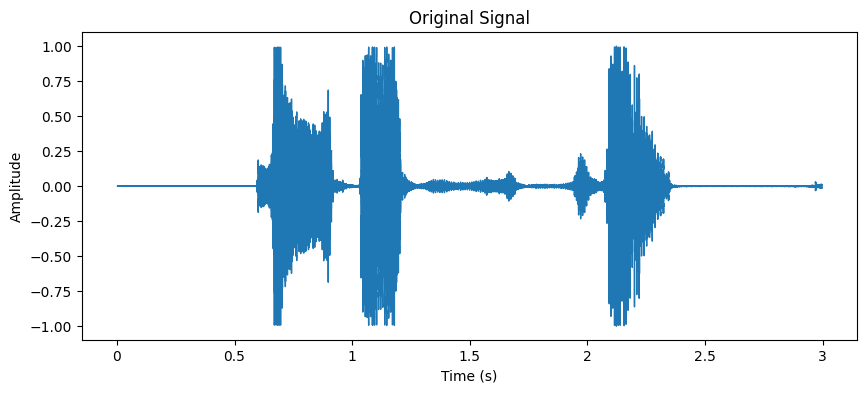

In [1]:
# Import necessary libraries
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.fftpack import dct
from sklearn.decomposition import PCA
import pickle

# Load the audio signal and sampling rate from the file
signal, fs = librosa.load('Record.wav', sr=None)

#################################################################################
#                      Visualization and Data Presentation                      #
#################################################################################

# Get the duration of the signal in seconds
duration = librosa.get_duration(y=signal, sr=fs)

# Calculate the number of samples in the signal
n_samples = len(signal)

# Calculate the max, min, and mean amplitude of the signal
max_amplitude = np.max(signal)
min_amplitude = np.min(signal)
mean_amplitude = np.mean(signal)

# Calculate the Root Mean Square (RMS) amplitude, a measure of the signal's power
rms_amplitude = librosa.feature.rms(y=signal).mean()

# Print the basic information about the audio signal
print(f'Sampling Rate: {fs} Hz')
print(f'Duration: {duration:.2f} seconds')
print(f'Number of Samples: {n_samples}')
print(f'Max Amplitude: {max_amplitude:.3f}')
print(f'Min Amplitude: {min_amplitude:.3f}')
print(f'Mean Amplitude: {mean_amplitude:.3f}')
print(f'RMS Amplitude: {rms_amplitude:.3f}')

# Plot the waveform of the original audio signal
plt.figure(figsize=(10, 4))
librosa.display.waveshow(signal, sr=fs)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.title('Original Signal')
plt.show()

# 2 - Pre-emphasis

Pre-emphasis is applied to the signal to amplify higher frequencies, which are typically weaker in speech. This step helps to balance the frequency spectrum, improving the signal-to-noise ratio for further analysis.

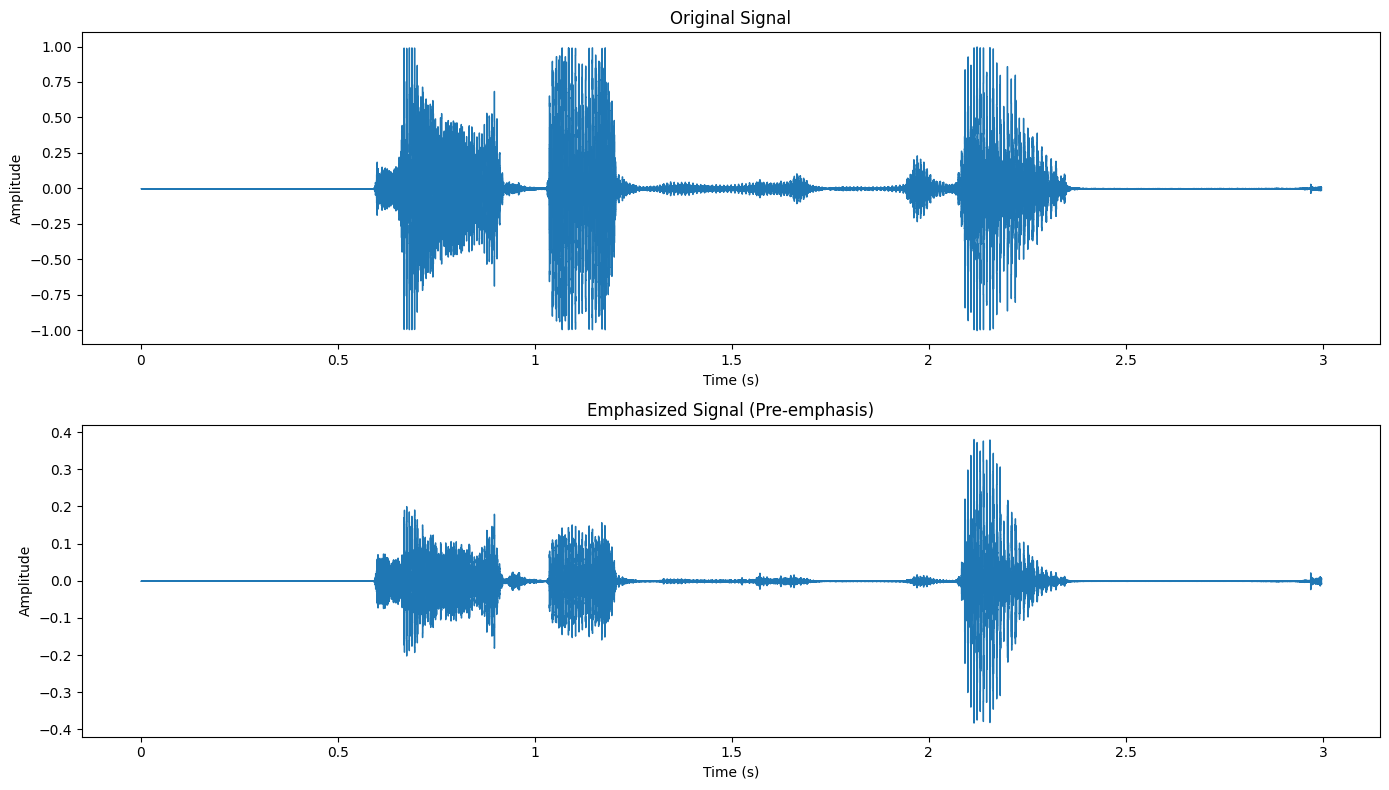

Original Signal - Mean: -0.0001, Standard Deviation: 0.1187
Emphasized Signal - Mean: -0.0000, Standard Deviation: 0.0229


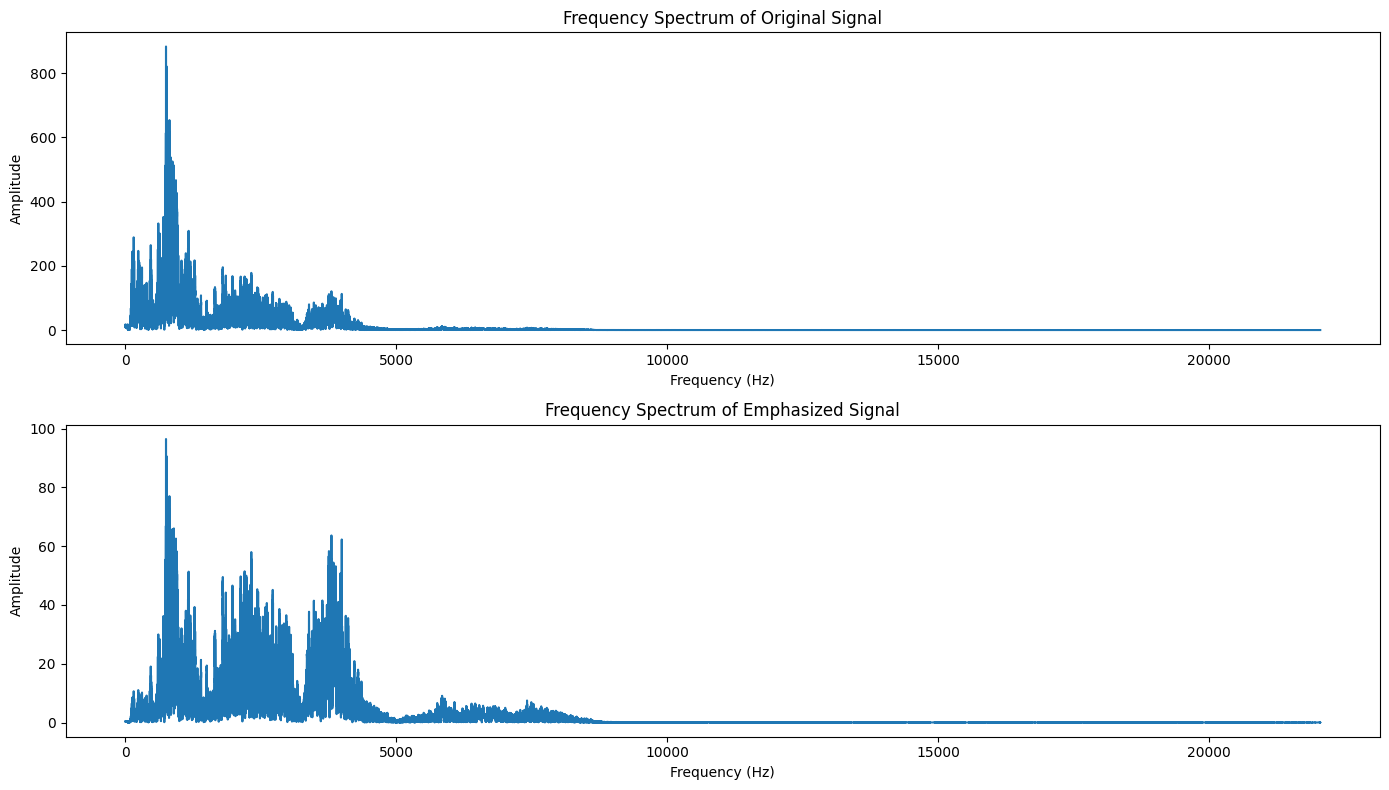

In [2]:
def pre_emphasis(signal, alpha=0.97):
    """
    Apply pre-emphasis to the input audio signal.

    Args:
        signal (numpy.ndarray): The input audio signal.
        alpha (float): Pre-emphasis filter coefficient. Default is 0.97.

    Returns:
        numpy.ndarray: The emphasized signal.
    """
    return np.append(signal[0], signal[1:] - alpha * signal[:-1])


# Apply pre-emphasis to the original signal
emphasized_signal = pre_emphasis(signal)

#################################################################################
#                      Visualization and Data Presentation                      #
#################################################################################

# Plot the original and emphasized (pre-emphasis) signals
plt.figure(figsize=(14, 8))

# Plot the original signal
plt.subplot(2, 1, 1)
librosa.display.waveshow(signal, sr=fs)
plt.title('Original Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')

# Plot the emphasized signal after pre-emphasis
plt.subplot(2, 1, 2)
librosa.display.waveshow(emphasized_signal, sr=fs)
plt.title('Emphasized Signal (Pre-emphasis)')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

# Calculate and print the mean and standard deviation of both signals
mean_original = np.mean(signal)
std_original = np.std(signal)
mean_emphasized = np.mean(emphasized_signal)
std_emphasized = np.std(emphasized_signal)

print(f'Original Signal - Mean: {mean_original:.4f}, Standard Deviation: {std_original:.4f}')
print(f'Emphasized Signal - Mean: {mean_emphasized:.4f}, Standard Deviation: {std_emphasized:.4f}')

# Compute the FFT of both original and emphasized signals
fft_original = np.fft.fft(signal)
fft_emphasized = np.fft.fft(emphasized_signal)

# Generate the frequency bins for the FFT
frequencies = np.fft.fftfreq(len(fft_original), d=1 / fs)

# Only take the first half of the frequency spectrum for plotting (positive frequencies)
half_n = len(frequencies) // 2

# Plot the frequency spectrum of the original and emphasized signals
plt.figure(figsize=(14, 8))

# Plot the frequency spectrum of the original signal
plt.subplot(2, 1, 1)
plt.plot(frequencies[:half_n], np.abs(fft_original[:half_n]))
plt.title('Frequency Spectrum of Original Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

# Plot the frequency spectrum of the emphasized signal
plt.subplot(2, 1, 2)
plt.plot(frequencies[:half_n], np.abs(fft_emphasized[:half_n]))
plt.title('Frequency Spectrum of Emphasized Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

# 3 - Windowing

In this step, the speech signal is divided into short overlapping frames by applying a window function (e.g., Hamming window). This allows for localized analysis of the signal in both time and frequency domains, necessary for short-term spectral processing.

Total number of frames: 298
Frame length (in samples): 1102


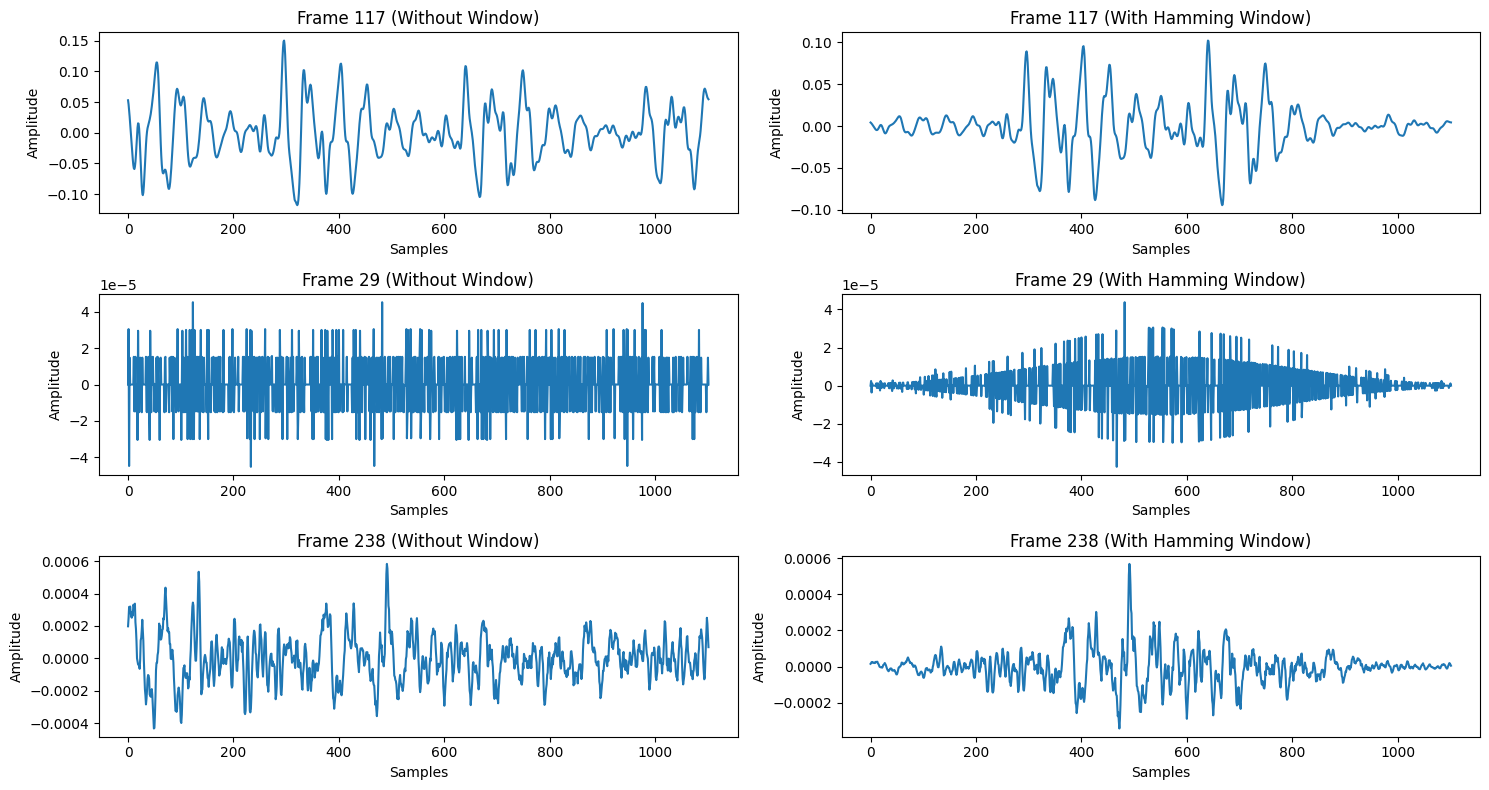

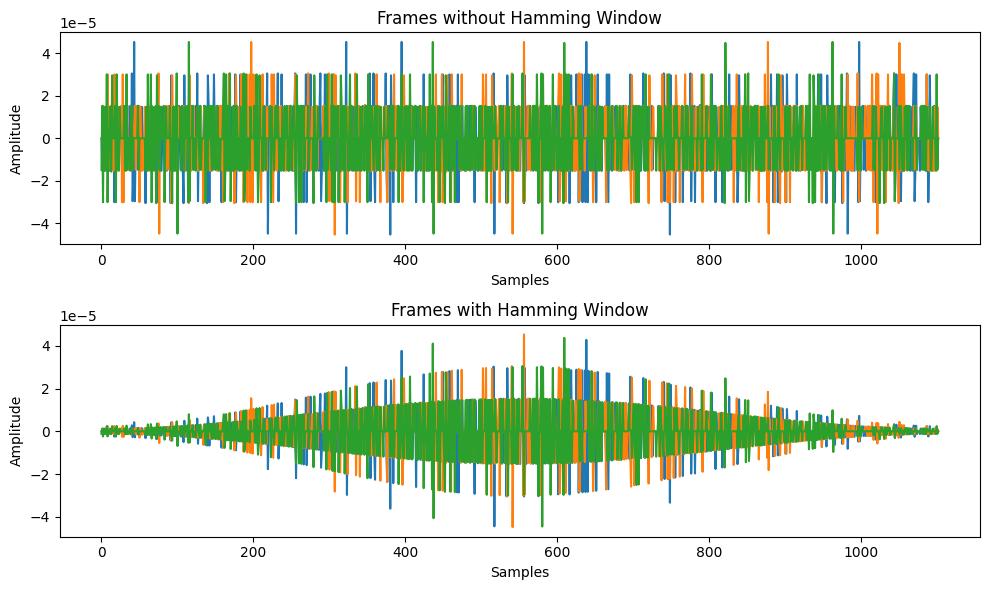

In [3]:
def framing(signal, frame_size, frame_stride, fs):
    """
    Frame the signal into overlapping frames and apply a window function (Hamming window).

    Args:
        signal (numpy.ndarray): The input audio signal.
        frame_size (float): Frame size in seconds.
        frame_stride (float): Frame stride in seconds.
        fs (int): Sampling rate of the signal.

    Returns:
        numpy.ndarray: A 2D array where each row is a frame of the signal.
    """
    # Convert frame size and stride from seconds to samples
    frame_length, frame_step = frame_size * fs, frame_stride * fs
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))

    # Calculate total number of frames and pad the signal if necessary
    signal_length = len(signal)
    total_frames = int(np.ceil(float(np.abs(signal_length - frame_length) / frame_step)))
    padded_signal_length = total_frames * frame_step + frame_length

    # Zero-padding the signal to match the required frame length
    zeros = np.zeros((padded_signal_length - signal_length))
    padded_signal = np.append(signal, zeros)

    # Create indices for frames (each row corresponds to a frame)
    indices = np.tile(np.arange(0, frame_length), (total_frames, 1)) + np.tile(np.arange(0, total_frames * frame_step, frame_step), (frame_length, 1)).T

    # Extract frames from the padded signal
    frames = padded_signal[indices.astype(np.int32, copy=False)]

    # Apply a Hamming window to each frame
    window = np.hamming(frame_length)
    frames_windowed = frames * window

    return frames, frames_windowed, frame_length, total_frames


# Define frame size and stride in seconds
frame_size = 0.025
frame_stride = 0.01

# Apply framing and windowing to the emphasized signal
frames, frames_windowed, frame_length, total_frames = framing(emphasized_signal, frame_size, frame_stride, fs)

#################################################################################
#                      Visualization and Data Presentation                      #
#################################################################################

# Print the total number of frames and frame length
print(f'Total number of frames: {total_frames}')
print(f'Frame length (in samples): {frame_length}')

# Plot a few random frames (both without and with windowing) for comparison
plt.figure(figsize=(15, 8))
random_frames = random.sample(range(total_frames), 3)
for i, frame_idx in enumerate(random_frames):
    # Plot frames without windowing
    plt.subplot(3, 2, 2 * i + 1)
    plt.plot(frames[frame_idx])
    plt.title(f'Frame {frame_idx} (Without Window)')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')

    # Plot frames with Hamming window applied
    plt.subplot(3, 2, 2 * i + 2)
    plt.plot(frames_windowed[frame_idx])
    plt.title(f'Frame {frame_idx} (With Hamming Window)')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

# Plot the first few frames (without and with Hamming window)
plt.figure(figsize=(10, 6))

# Frames without windowing
plt.subplot(2, 1, 1)
for i in range(3):
    plt.plot(frames[i], label=f'Frame {i}')
plt.title('Frames without Hamming Window')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

# Frames with Hamming window
plt.subplot(2, 1, 2)
for i in range(3):
    plt.plot(frames_windowed[i], label=f'Frame {i}')
plt.title('Frames with Hamming Window')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

# 4 - Short-Time Fourier Transform (STFT)

STFT is used to convert the windowed time-domain signal into the frequency domain. Each frame is transformed into its frequency components, producing a spectrogram that represents how frequencies evolve over time.

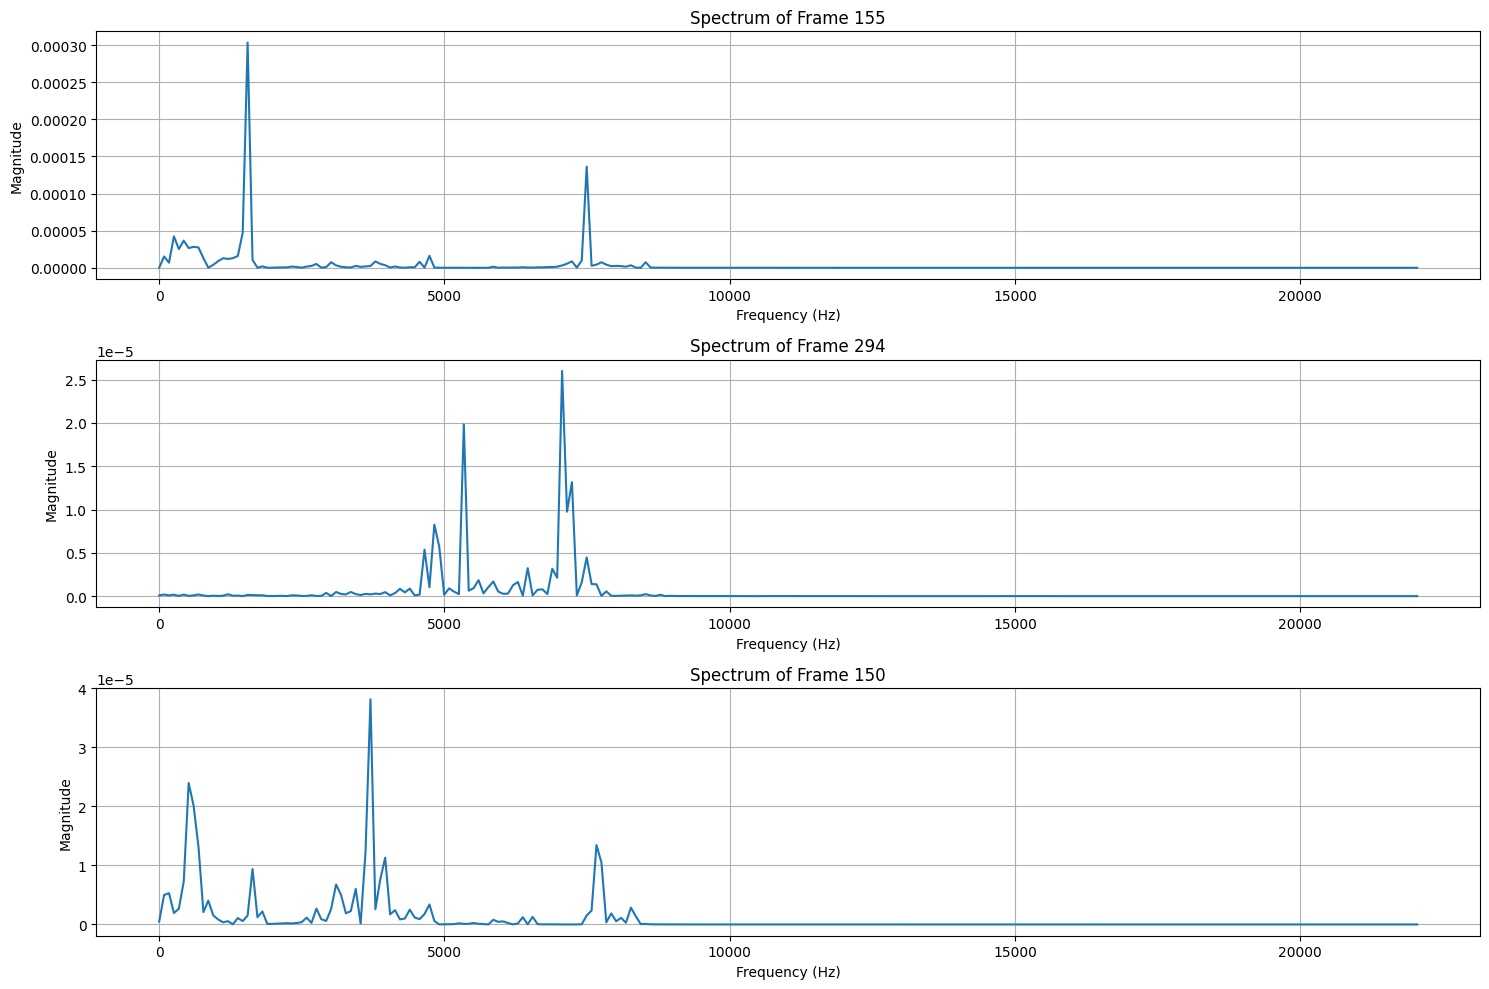

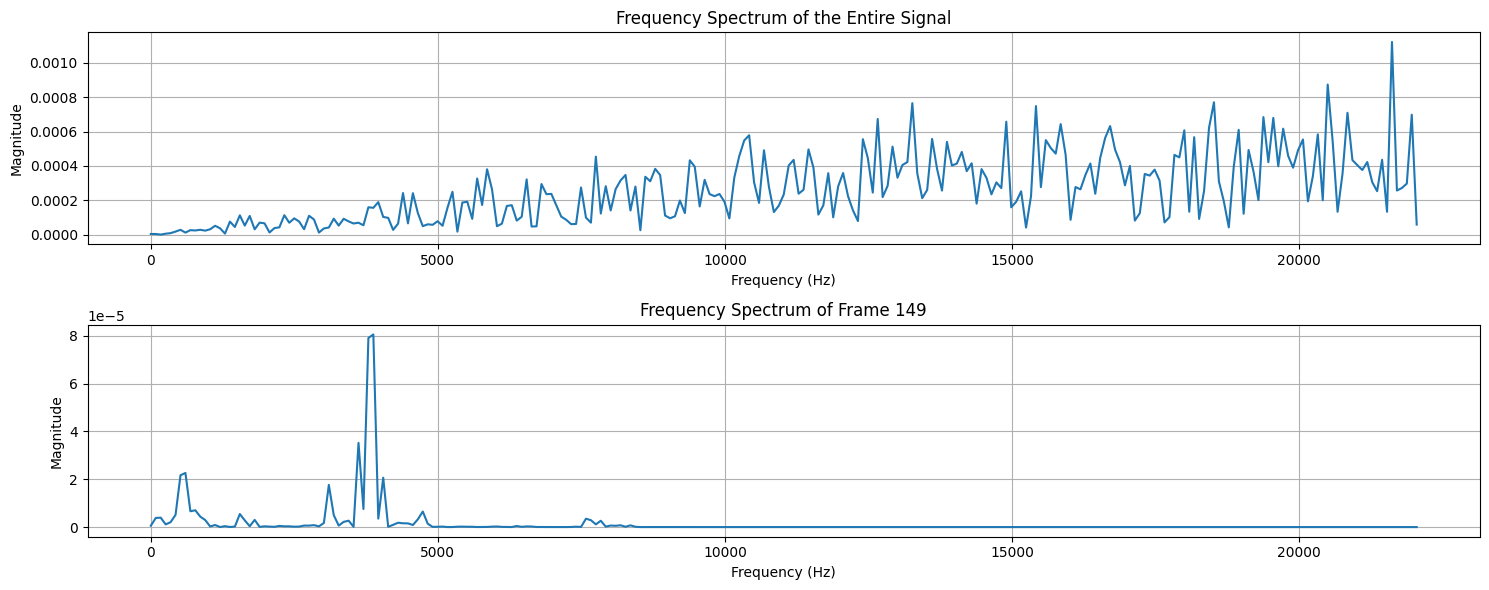

C:\Users\lenovo\AppData\Local\Temp\ipykernel_24784\1857639190.py:78: RuntimeWarning: divide by zero encountered in log10
  spectrum_dB = 10 * np.log10(spectrum.T)


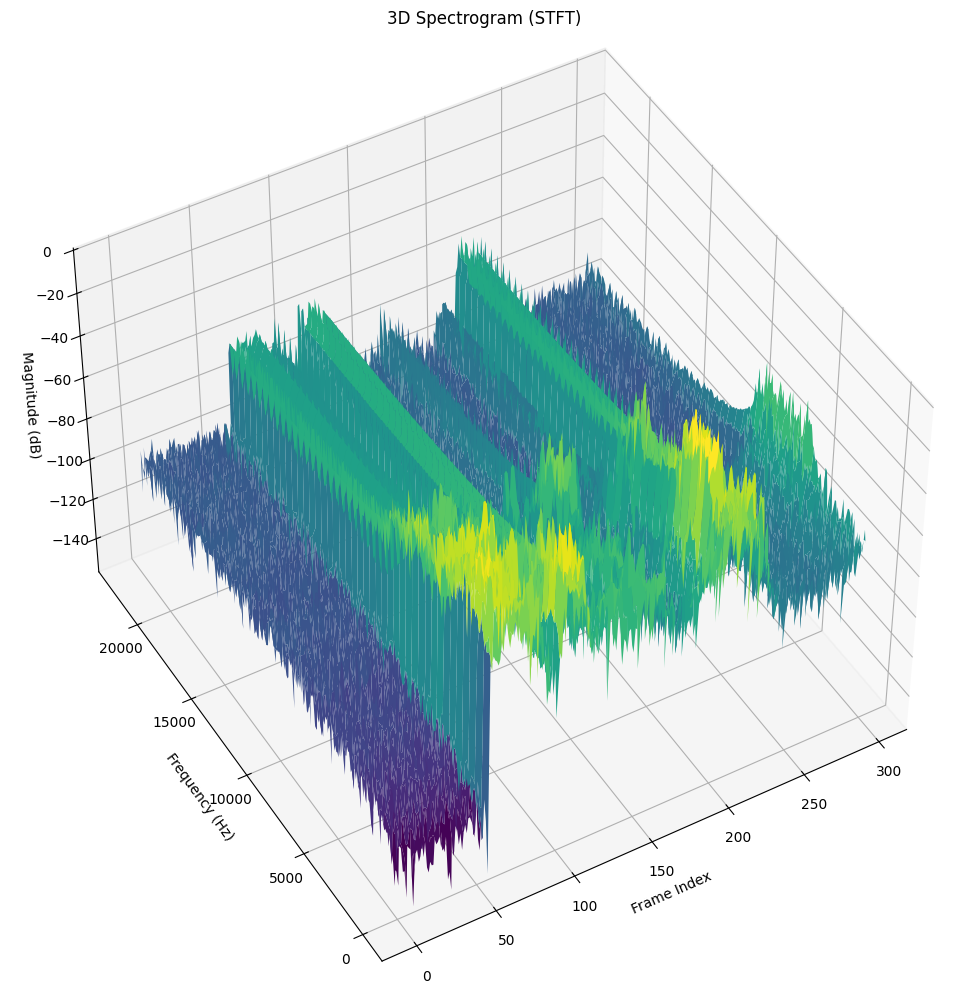

In [4]:
def stft(frames, NFFT):
    """
    Perform Short-Time Fourier Transform on the input frames.

    Args:
        frames (numpy.ndarray): The input frames, each row is a frame.
        NFFT (int): Number of FFT points, determines the frequency resolution.

    Returns:
        numpy.ndarray: The magnitude spectrum of each frame.
    """
    # Compute the magnitude of the FFT for each frame
    mag_frames = np.abs(np.fft.rfft(frames, NFFT))

    # Compute the power spectrum (squared magnitude normalized by the number of FFT points)
    pow_frames = ((1.0 / NFFT) * (mag_frames ** 2))

    return pow_frames


# Set the number of FFT points (frequency resolution)
NFFT = 512

# Perform STFT on the frames
spectrum = stft(frames, NFFT)

#################################################################################
#                      Visualization and Data Presentation                      #
#################################################################################

# Plot the spectrum of a few random frames
plt.figure(figsize=(15, 10))
random_frames = random.sample(range(frames.shape[0]), 3)
frequencies = np.linspace(0, fs / 2, NFFT // 2 + 1)
for i, frame_idx in enumerate(random_frames):
    plt.subplot(3, 1, i + 1)
    plt.plot(frequencies, spectrum[frame_idx])
    plt.title(f'Spectrum of Frame {frame_idx}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid()
plt.tight_layout()
plt.show()

# Compute and plot the frequency spectrum of the entire emphasized signal
fft_full = np.abs(np.fft.rfft(emphasized_signal, NFFT))

plt.figure(figsize=(15, 6))
# Plot the spectrum of the entire signal
plt.subplot(2, 1, 1)
plt.plot(frequencies, fft_full)
plt.title('Frequency Spectrum of the Entire Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()

# Plot the spectrum of a randomly selected frame
random_frame_idx = random.choice(range(frames.shape[0]))
plt.subplot(2, 1, 2)
plt.plot(frequencies, spectrum[random_frame_idx])
plt.title(f'Frequency Spectrum of Frame {random_frame_idx}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.tight_layout()
plt.show()

# 3D plot of the spectrogram (STFT) in dB scale
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Meshgrid for time (frame index) and frequency
time_indices = np.arange(frames.shape[0])
freq_indices = np.linspace(0, fs / 2, NFFT // 2 + 1)
time_mesh, freq_mesh = np.meshgrid(time_indices, freq_indices)

# Convert spectrum to dB scale
spectrum_dB = 10 * np.log10(spectrum.T)

# Create a 3D surface plot of the spectrogram
ax.plot_surface(time_mesh, freq_mesh, spectrum_dB, cmap='viridis', edgecolor='none')
ax.set_title('3D Spectrogram (STFT)')
ax.set_xlabel('Frame Index')
ax.set_ylabel('Frequency (Hz)')
ax.set_zlabel('Magnitude (dB)')

# Set the viewing angle for better visualization
ax.view_init(45, -120)
plt.tight_layout()
plt.show()

# 5 - Mel-filter Bank

The Mel-filter bank is applied to the STFT output to approximate human hearing perception. It compresses the frequency scale to focus more on lower frequencies, mimicking how humans perceive sound. This results in the Mel spectrum.

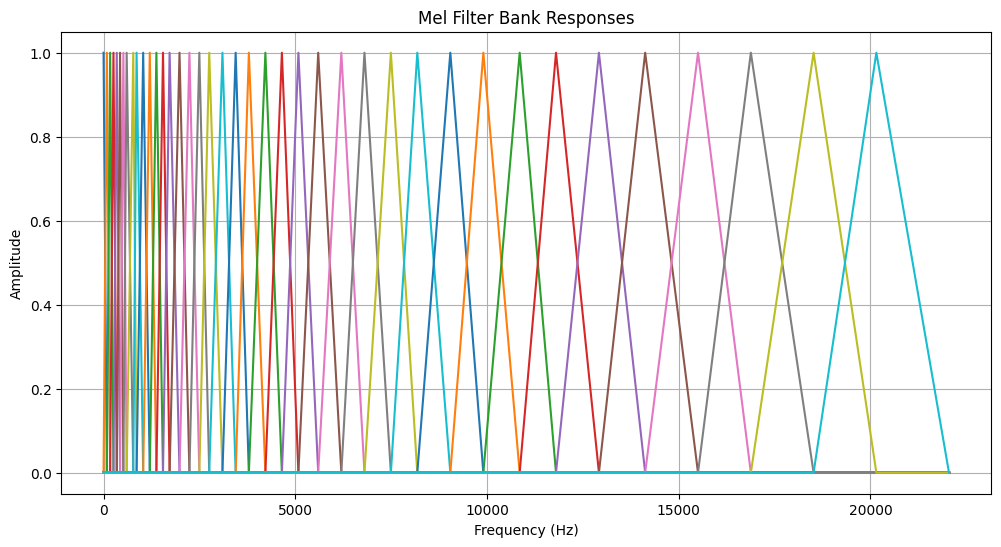

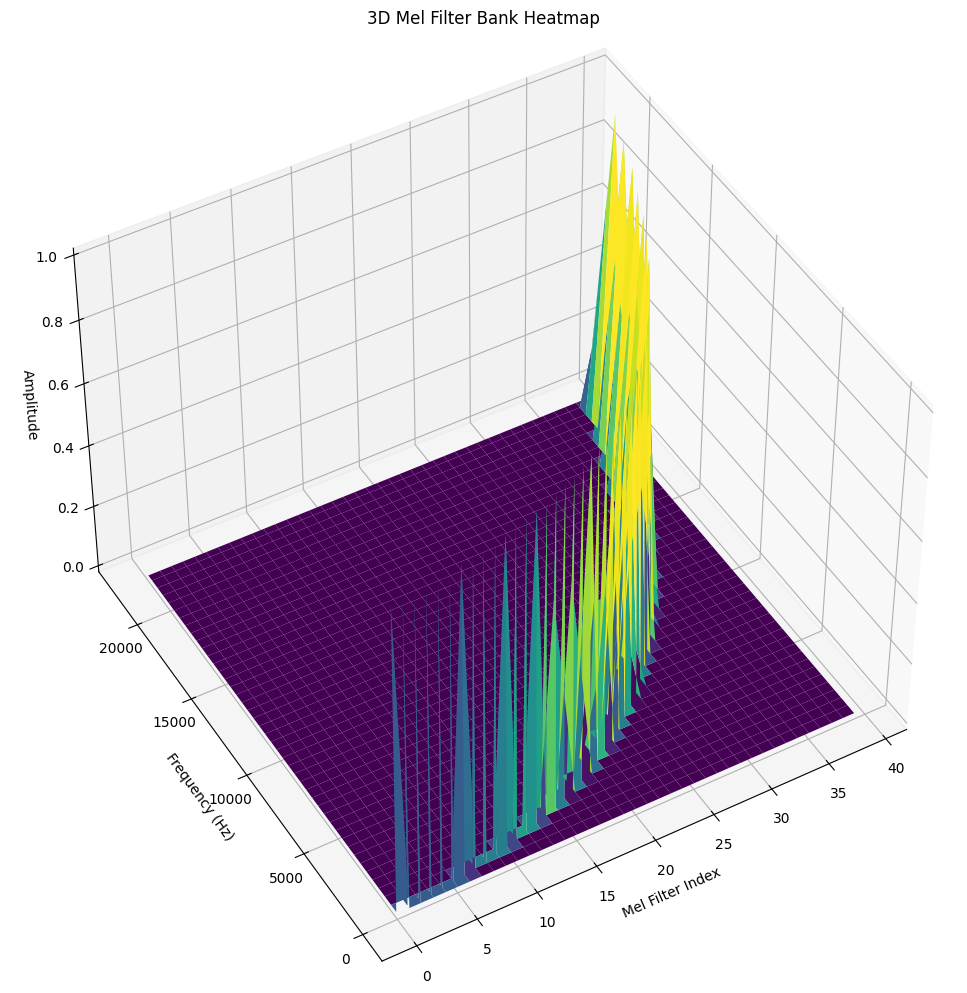

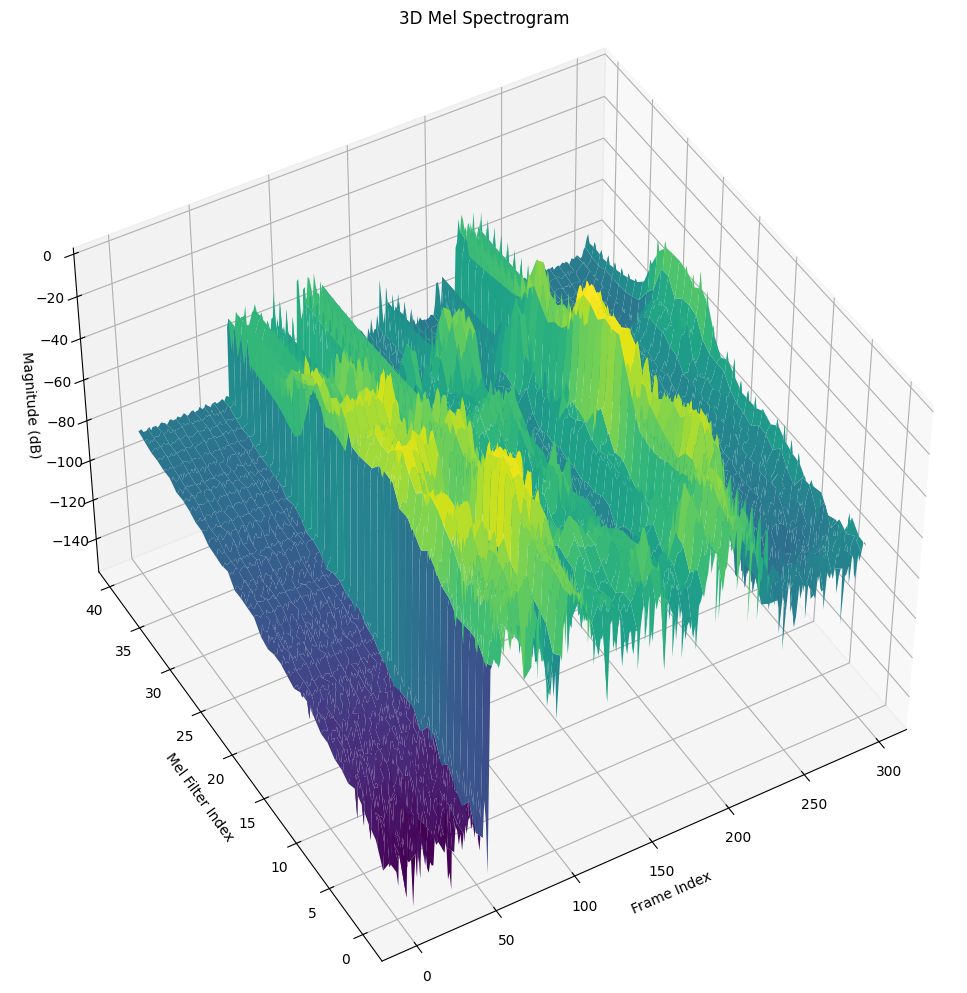

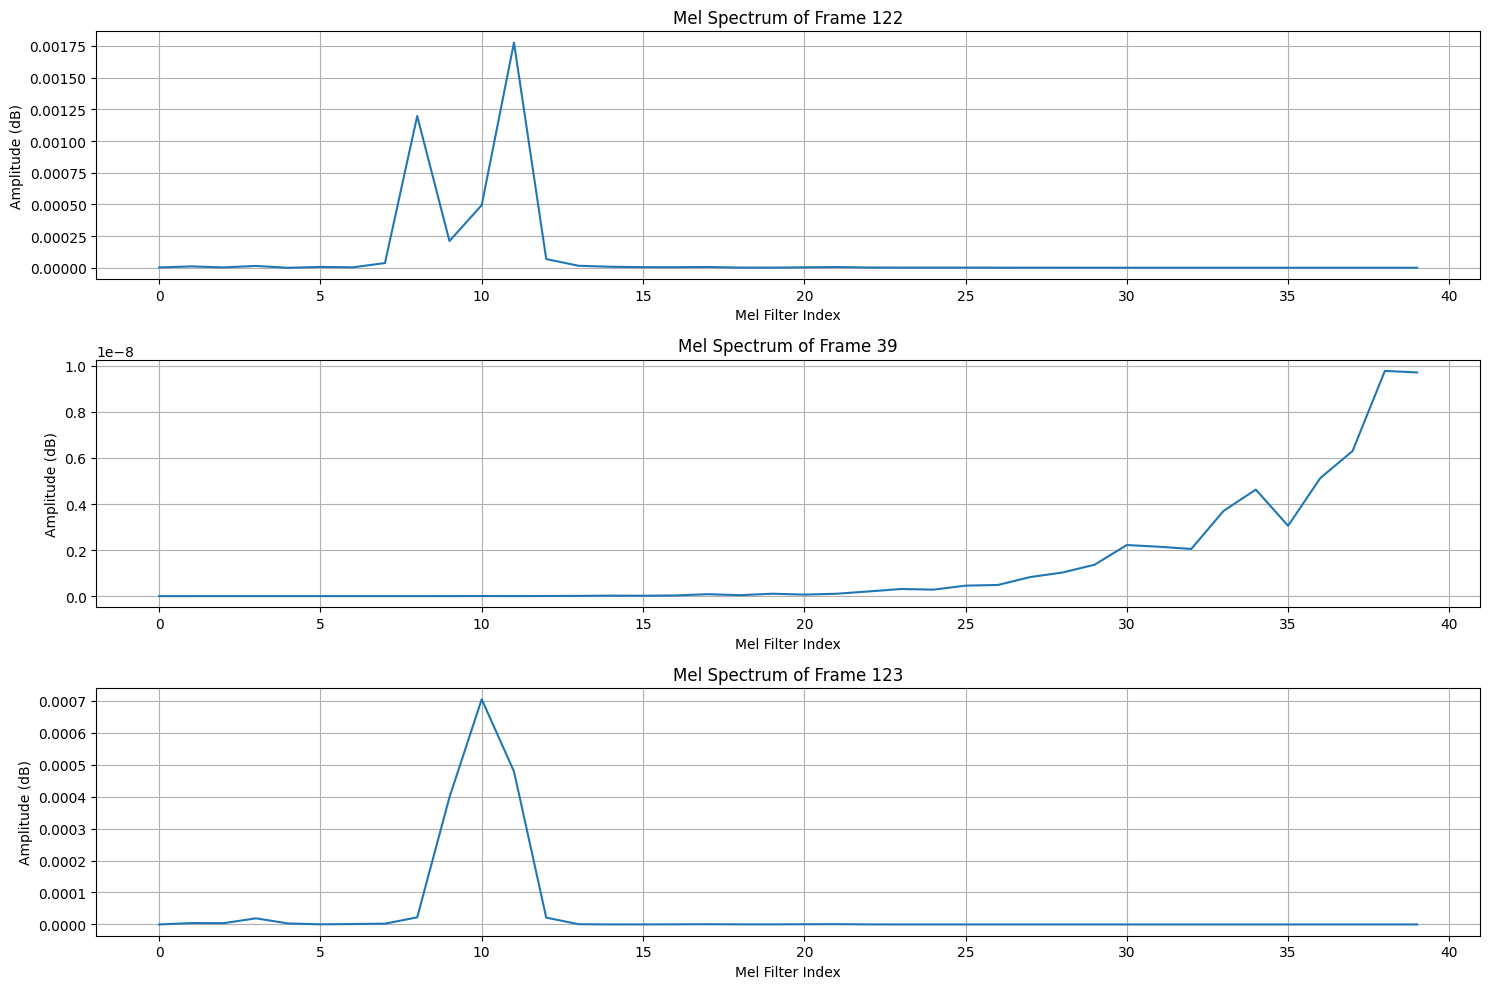

In [5]:
def mel_filter_bank(num_filters, NFFT, fs):
    """
    Generate Mel filter banks.

    Args:
        num_filters (int): The number of Mel filters.
        NFFT (int): Number of FFT points, determines frequency resolution.
        fs (int): Sampling rate of the signal.

    Returns:
        numpy.ndarray: Mel filter banks, shape (num_filters, NFFT // 2 + 1).
    """
    # Convert the low and high frequencies to the Mel scale
    low_freq_mel = 0
    high_freq_mel = 2595 * np.log10(1 + (fs / 2) / 700)

    # Create evenly spaced Mel points
    mel_points = np.linspace(low_freq_mel, high_freq_mel, num_filters + 2)

    # Convert Mel points back to Hz
    hz_points = 700 * (10 ** (mel_points / 2595) - 1)

    # Map Hz points to corresponding FFT bin numbers
    bin_points = np.floor((NFFT + 1) * hz_points / fs)

    # Initialize the filter bank matrix
    filters = np.zeros((num_filters, int(np.floor(NFFT / 2 + 1))))

    # Create triangular filters between successive Mel points
    for m in range(1, num_filters + 1):
        f_m_minus = int(bin_points[m - 1])
        f_m = int(bin_points[m])
        f_m_plus = int(bin_points[m + 1])

        # Construct the left side of the triangular filter
        for k in range(f_m_minus, f_m):
            filters[m - 1, k] = (k - bin_points[m - 1]) / (bin_points[m] - bin_points[m - 1])

        # Construct the right side of the triangular filter
        for k in range(f_m, f_m_plus):
            filters[m - 1, k] = (bin_points[m + 1] - k) / (bin_points[m + 1] - bin_points[m])

    return filters

# Set the number of Mel filters
num_filters = 40

# Generate the Mel filter bank and apply it to the spectrum
filters = mel_filter_bank(num_filters, NFFT, fs)
mel_spectrum = np.dot(spectrum, filters.T)

# Replace zero values in the Mel spectrum with a small positive value to avoid log issues
mel_spectrum = np.where(mel_spectrum == 0, np.finfo(float).eps, mel_spectrum)

#################################################################################
#                      Visualization and Data Presentation                      #
#################################################################################

# Plot the Mel filter bank responses (triangular filters)
plt.figure(figsize=(12, 6))
for i in range(num_filters):
    plt.plot(np.linspace(0, fs / 2, int(NFFT / 2) + 1), filters[i])
plt.title('Mel Filter Bank Responses')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

# 3D plot of the Mel filter bank responses
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Create a meshgrid for the Mel filter indices and frequency bins
mel_filter_indices = np.arange(filters.shape[0])
freq_bins = np.linspace(0, fs / 2, int(NFFT / 2) + 1)
filter_mesh, freq_mesh = np.meshgrid(mel_filter_indices, freq_bins)

# Plot the 3D surface of Mel filter bank responses
filter_responses = filters.T
ax.plot_surface(filter_mesh, freq_mesh, filter_responses, cmap='viridis', edgecolor='none')
ax.set_title('3D Mel Filter Bank Heatmap')
ax.set_xlabel('Mel Filter Index')
ax.set_ylabel('Frequency (Hz)')
ax.set_zlabel('Amplitude')
ax.view_init(45, -120)
plt.tight_layout()
plt.show()

# 3D plot of the Mel spectrogram
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Meshgrid for time (frame index) and Mel filter index
time_indices = np.arange(mel_spectrum.shape[0])
mel_indices = np.arange(mel_spectrum.shape[1])
time_mesh, mel_mesh = np.meshgrid(time_indices, mel_indices)

# Convert Mel spectrum to dB scale
mel_spectrum_dB = 10 * np.log10(mel_spectrum.T)

# Plot the 3D surface of the Mel spectrogram
ax.plot_surface(time_mesh, mel_mesh, mel_spectrum_dB, cmap='viridis', edgecolor='none')
ax.set_title('3D Mel Spectrogram')
ax.set_xlabel('Frame Index')
ax.set_ylabel('Mel Filter Index')
ax.set_zlabel('Magnitude (dB)')
ax.view_init(45, -120)
plt.tight_layout()
plt.show()

# Plot the Mel spectrum of a few random frames
plt.figure(figsize=(15, 10))
random_frames = random.sample(range(mel_spectrum.shape[0]), 3)
for i, frame_idx in enumerate(random_frames):
    plt.subplot(3, 1, i + 1)
    plt.plot(mel_spectrum[frame_idx])
    plt.title(f'Mel Spectrum of Frame {frame_idx}')
    plt.xlabel('Mel Filter Index')
    plt.ylabel('Amplitude (dB)')
    plt.grid()
plt.tight_layout()
plt.show()

# 6 - Log Transformation

After applying the Mel-filter bank, we take the logarithm of the Mel spectrum to convert the amplitudes to a logarithmic scale, which aligns with how the human ear perceives sound intensity changes.

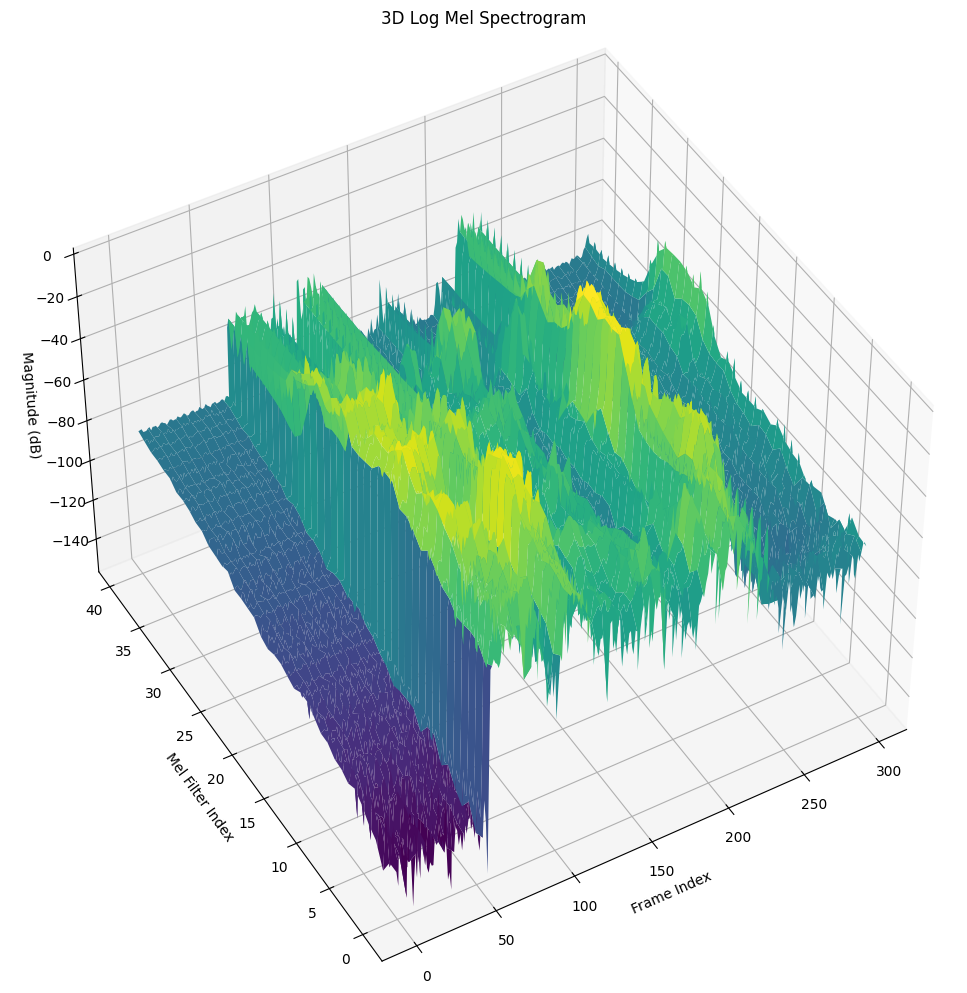

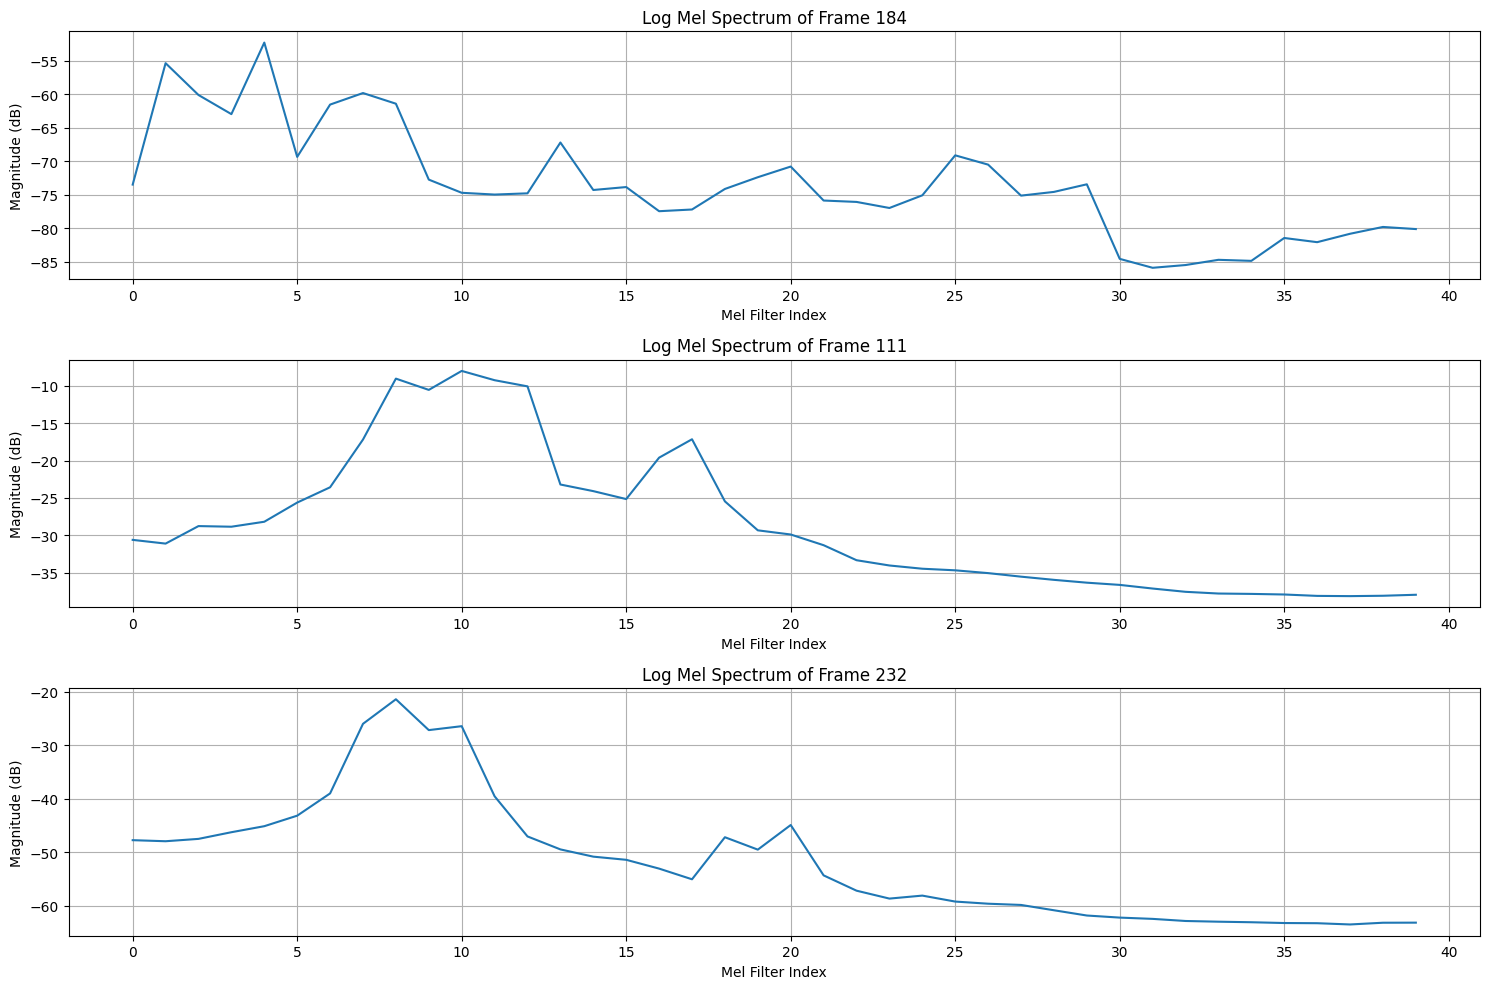

In [6]:
def log_magnitude(x):
    """
    Apply logarithmic compression to the input spectrum to simulate human perception.

    Args:
        x (numpy.ndarray): The input spectrum (e.g., Mel spectrum).

    Returns:
        numpy.ndarray: The logarithmically compressed spectrum.
    """
    # Convert to logarithmic scale (in dB)
    return 10 * np.log10(x)

# Apply log transformation to the Mel spectrum
log_mel_spectrum = log_magnitude(mel_spectrum)

#################################################################################
#                      Visualization and Data Presentation                      #
#################################################################################

# 3D plot of the log Mel spectrogram
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Create meshgrid for time (frame index) and Mel filter index
time_indices = np.arange(log_mel_spectrum.shape[0])
mel_indices = np.arange(log_mel_spectrum.shape[1])
time_mesh, mel_mesh = np.meshgrid(time_indices, mel_indices)

# Transpose the log Mel spectrum for 3D plotting
log_mel_spectrum_dB = log_mel_spectrum.T

# Plot the 3D surface of the log Mel spectrogram
ax.plot_surface(time_mesh, mel_mesh, log_mel_spectrum_dB, cmap='viridis', edgecolor='none')
ax.set_title('3D Log Mel Spectrogram')
ax.set_xlabel('Frame Index')
ax.set_ylabel('Mel Filter Index')
ax.set_zlabel('Magnitude (dB)')
ax.view_init(45, -120)
plt.tight_layout()
plt.show()

# Plot the log Mel spectrum for a few random frames
plt.figure(figsize=(15, 10))
random_frames = random.sample(range(log_mel_spectrum.shape[0]), 3)
for i, frame_idx in enumerate(random_frames):
    plt.subplot(3, 1, i + 1)
    plt.plot(log_mel_spectrum[frame_idx])
    plt.title(f'Log Mel Spectrum of Frame {frame_idx}')
    plt.xlabel('Mel Filter Index')
    plt.ylabel('Magnitude (dB)')
    plt.grid()
plt.tight_layout()
plt.show()

# 7 - Discrete Cosine Transform (DCT)

DCT is applied to the log Mel spectrum to obtain the Mel Frequency Cepstral Coefficients (MFCCs). These coefficients represent the most important characteristics of the speech signal and are often used for tasks like speech recognition.

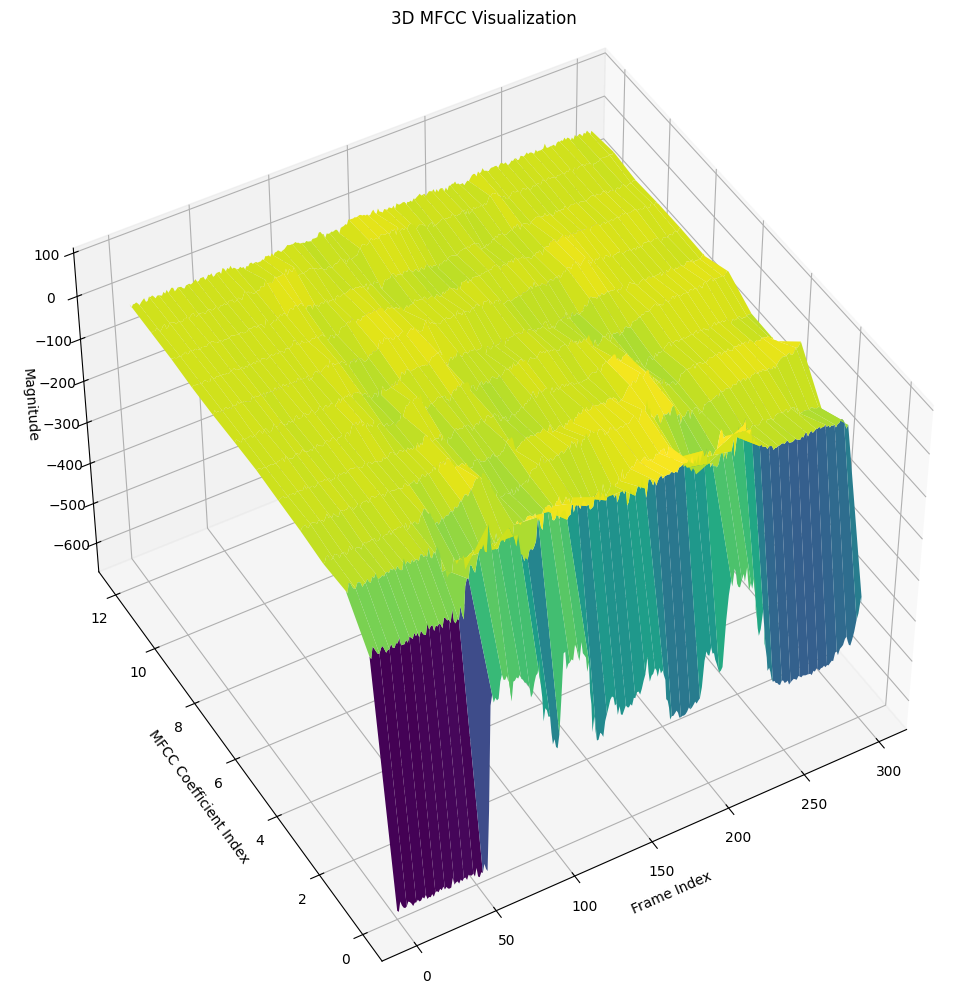

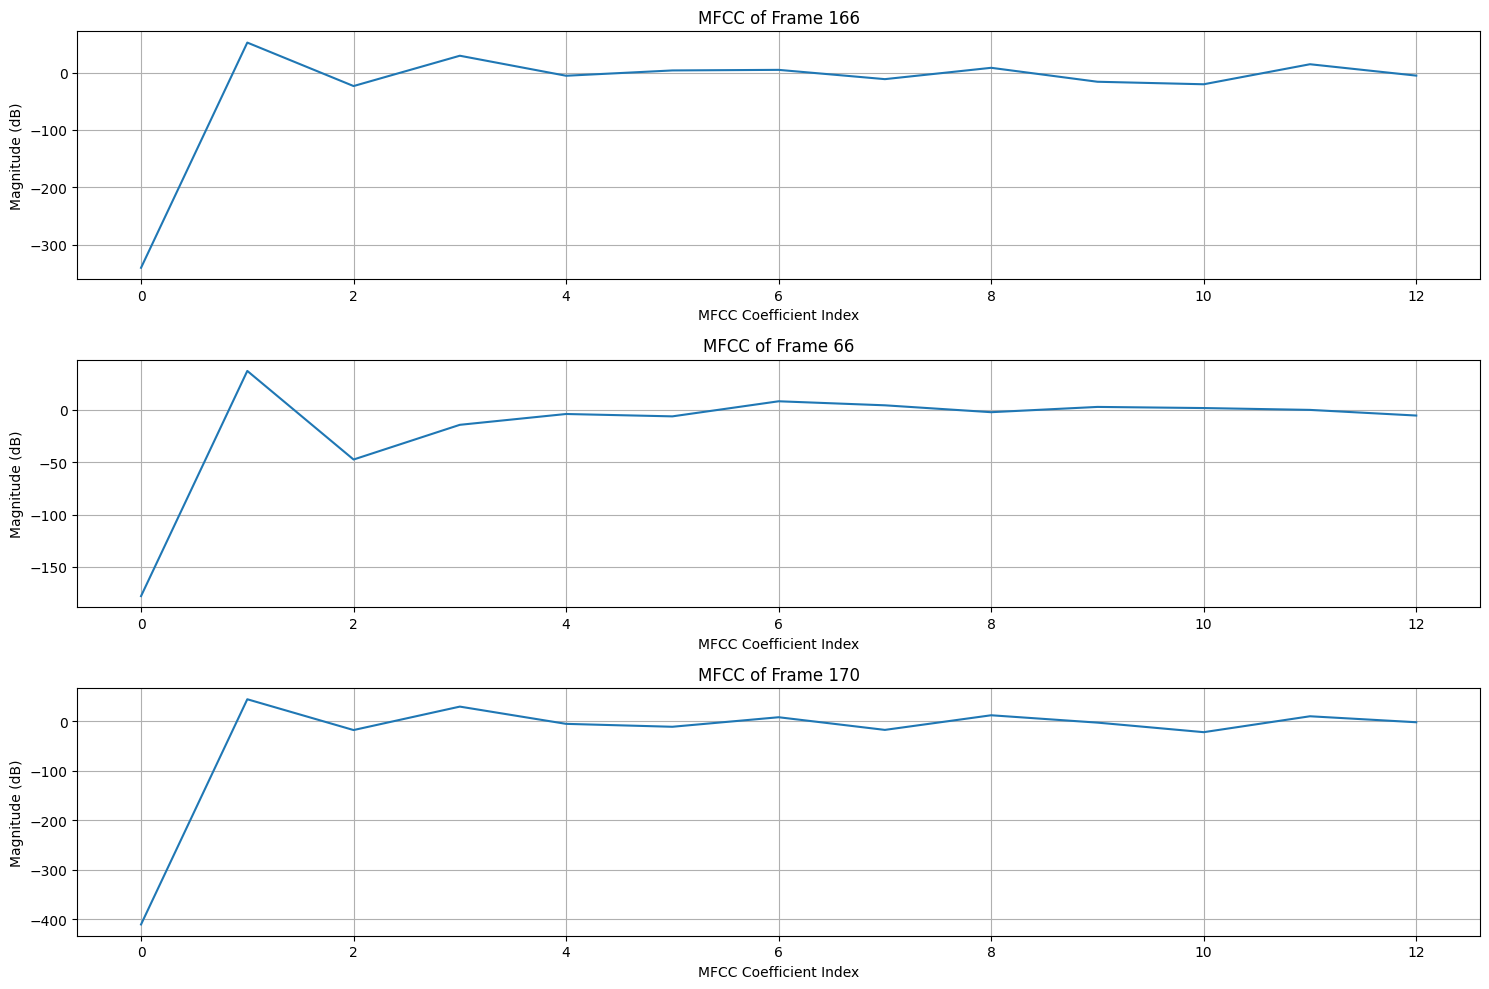

In [7]:
# Apply DCT to the log Mel spectrum to compute MFCC features
mfcc_features = dct(log_mel_spectrum, type=2, axis=1, norm='ortho')[:, :13]

#################################################################################
#                      Visualization and Data Presentation                      #
#################################################################################

# 3D plot of the MFCC features
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Create meshgrid for time (frame index) and MFCC coefficient index
time_indices = np.arange(mfcc_features.shape[0])
mfcc_indices = np.arange(mfcc_features.shape[1])
time_mesh, mfcc_mesh = np.meshgrid(time_indices, mfcc_indices)

# Transpose the MFCC features for 3D plotting
mfcc_features_3d = mfcc_features.T

# Plot the 3D surface of the MFCC features
ax.plot_surface(time_mesh, mfcc_mesh, mfcc_features_3d, cmap='viridis', edgecolor='none')
ax.set_title('3D MFCC Visualization')
ax.set_xlabel('Frame Index')
ax.set_ylabel('MFCC Coefficient Index')
ax.set_zlabel('Magnitude')
ax.view_init(45, -120)
plt.tight_layout()
plt.show()

# Plot the MFCCs for a few random frames
random_frames = random.sample(range(mfcc_features.shape[0]), 3)

plt.figure(figsize=(15, 10))
for i, frame_idx in enumerate(random_frames):
    plt.subplot(3, 1, i + 1)
    plt.plot(mfcc_features[frame_idx])
    plt.title(f'MFCC of Frame {frame_idx}')
    plt.xlabel('MFCC Coefficient Index')
    plt.ylabel('Magnitude (dB)')
    plt.grid()
plt.tight_layout()
plt.show()

# 8 - Dynamic Feature Extraction

In this step, the first-order (Delta) and second-order (Delta-Delta) derivatives of MFCCs are calculated. These dynamic features capture changes in the speech signal over time, providing additional temporal information.

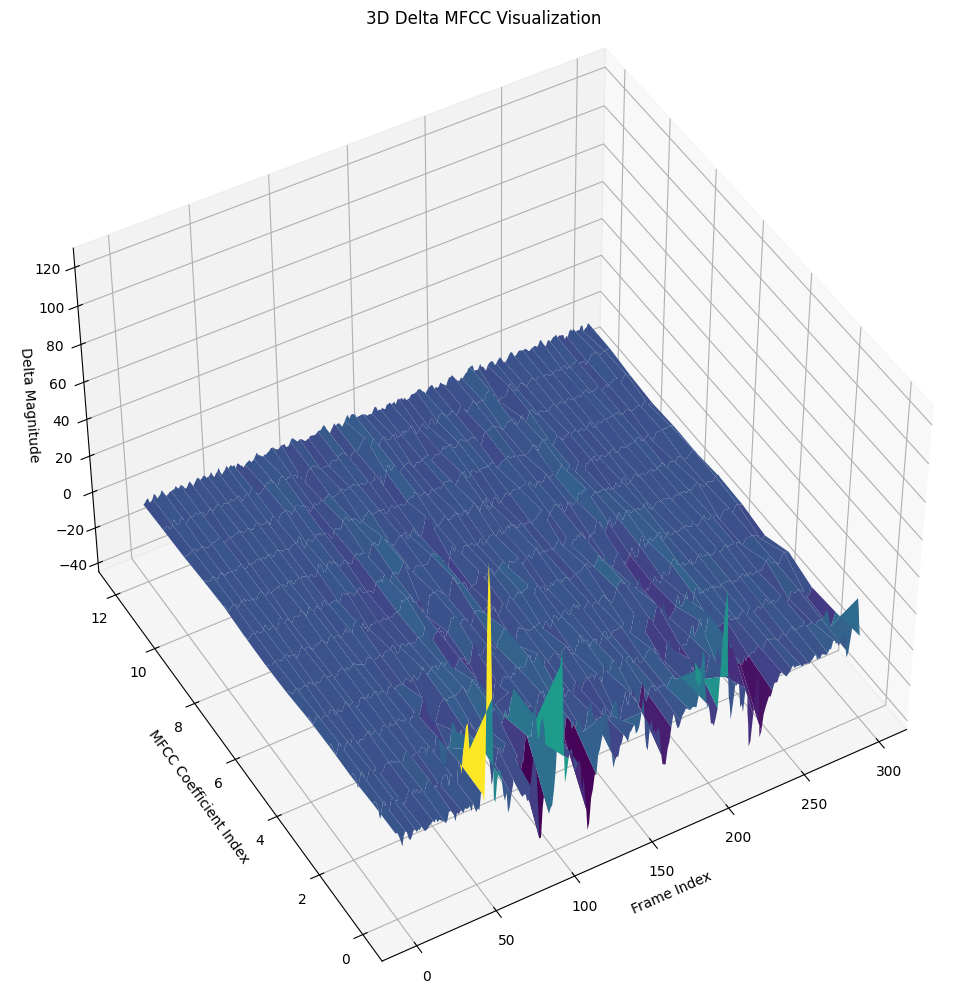

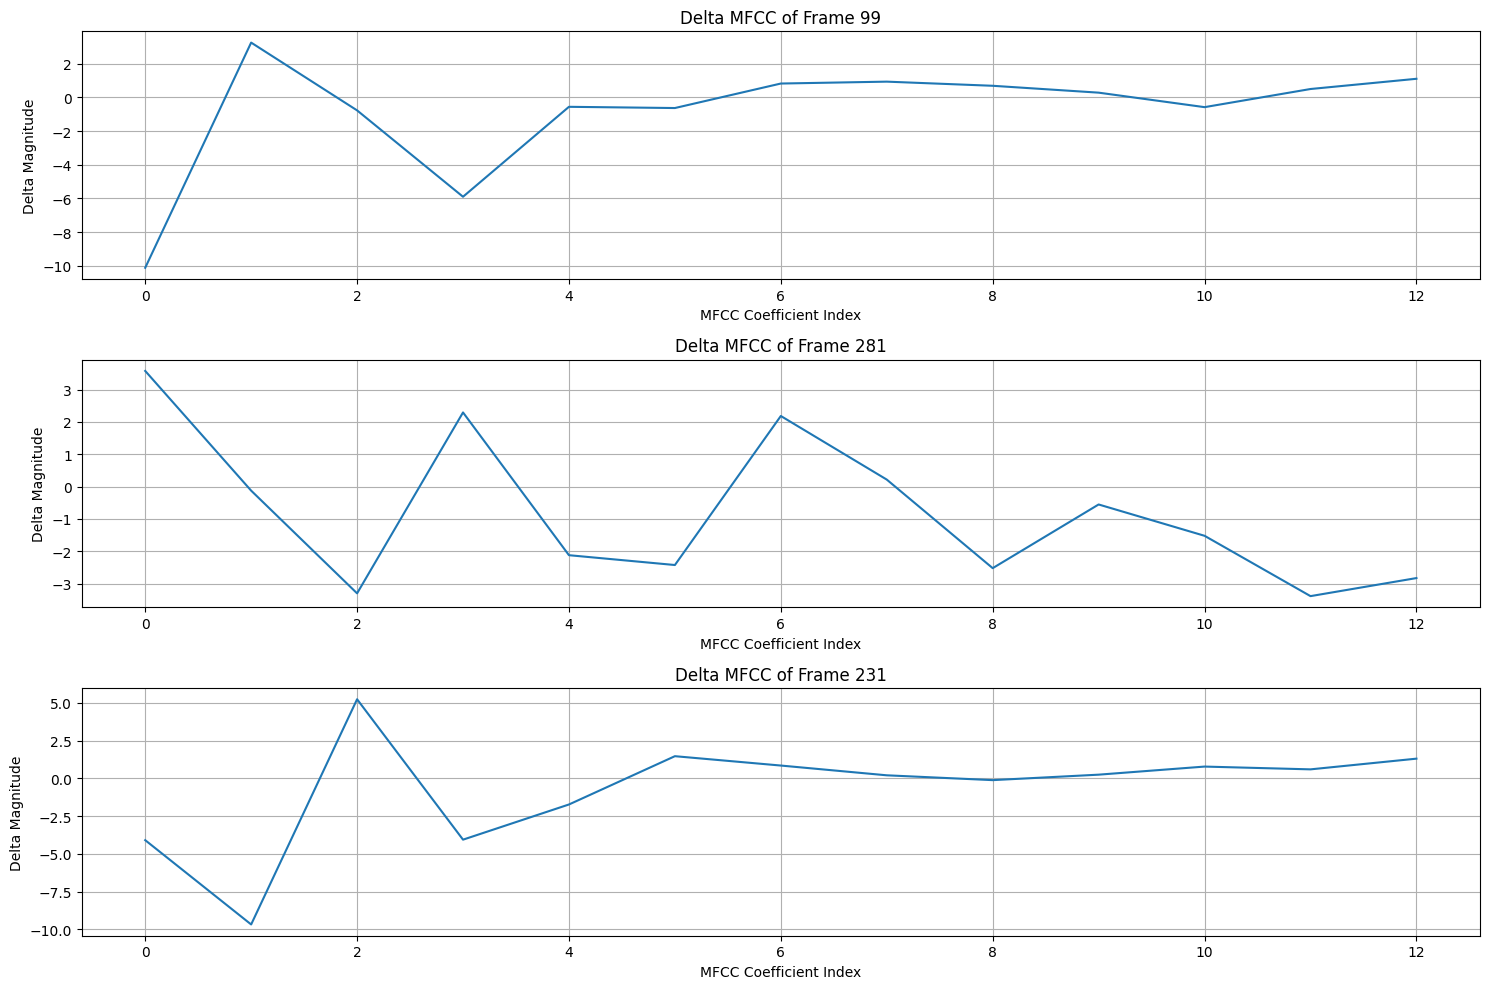

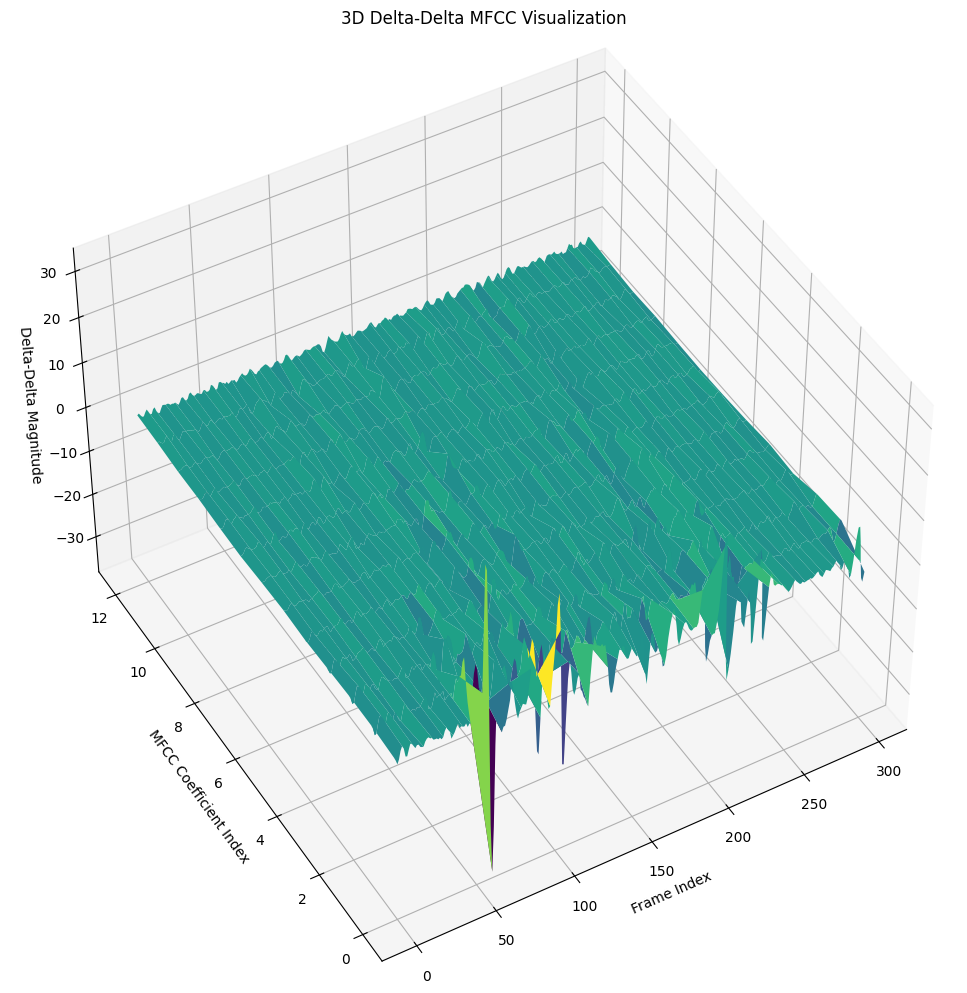

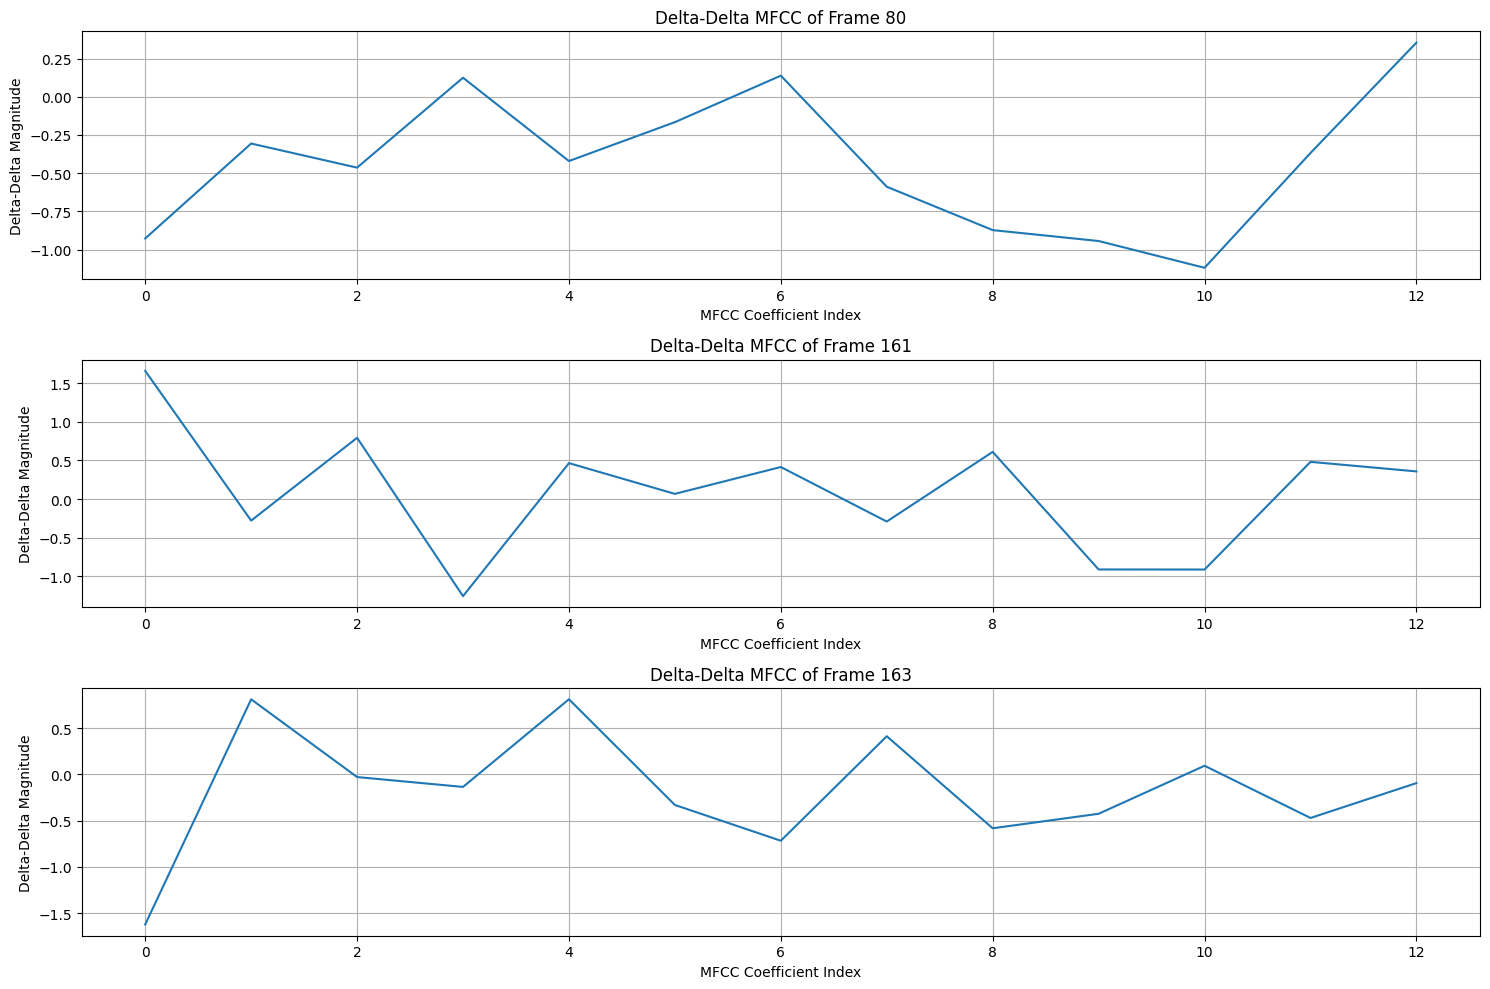

In [8]:
def delta(feature_matrix, N=2):
    """
    Calculate delta (derivative) of the feature matrix.

    Args:
        feature_matrix (numpy.ndarray): Input feature matrix (e.g., MFCCs).
        N (int): The window size for calculating the delta.

    Returns:
        numpy.ndarray: Delta feature matrix.
    """
    # Number of frames in the feature matrix
    num_frames, _ = feature_matrix.shape

    # Denominator for the delta calculation
    denominator = 2 * sum([i ** 2 for i in range(1, N + 1)])

    # Initialize the delta feature matrix with the same shape
    delta_feature = np.empty_like(feature_matrix)

    # Pad the feature matrix at the edges to handle boundary conditions
    padded = np.pad(feature_matrix, ((N, N), (0, 0)), mode='edge')

    # Compute the delta for each frame
    for t in range(num_frames):
        delta_feature[t] = np.dot(np.arange(-N, N + 1), padded[t: t + 2 * N + 1]) / denominator

    return delta_feature

# Compute the first-order delta (Delta) of the MFCC features
delta1 = delta(mfcc_features)

# Compute the second-order delta (Delta-Delta) of the first-order delta
delta2 = delta(delta1)

#################################################################################
#                      Visualization and Data Presentation                      #
#################################################################################

# 3D plot of the first-order Delta MFCC features
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Create meshgrid for time (frame index) and MFCC coefficient index
time_indices = np.arange(delta1.shape[0])
mfcc_indices = np.arange(delta1.shape[1])
time_mesh, mfcc_mesh = np.meshgrid(time_indices, mfcc_indices)

# Transpose the Delta MFCC for 3D plotting
delta1_3d = delta1.T

# Plot the 3D surface of the Delta MFCC features
ax.plot_surface(time_mesh, mfcc_mesh, delta1_3d, cmap='viridis', edgecolor='none')
ax.set_title('3D Delta MFCC Visualization')
ax.set_xlabel('Frame Index')
ax.set_ylabel('MFCC Coefficient Index')
ax.set_zlabel('Delta Magnitude')
ax.view_init(45, -120)
plt.tight_layout()
plt.show()

# Plot the Delta MFCCs for a few random frames
random_frames = random.sample(range(delta1.shape[0]), 3)

plt.figure(figsize=(15, 10))
for i, frame_idx in enumerate(random_frames):
    plt.subplot(3, 1, i + 1)
    plt.plot(delta1[frame_idx])
    plt.title(f'Delta MFCC of Frame {frame_idx}')
    plt.xlabel('MFCC Coefficient Index')
    plt.ylabel('Delta Magnitude')
    plt.grid()
plt.tight_layout()
plt.show()

# 3D plot of the second-order Delta-Delta MFCC features
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Create meshgrid for time (frame index) and MFCC coefficient index
time_indices = np.arange(delta2.shape[0])
mfcc_indices = np.arange(delta2.shape[1])
time_mesh, mfcc_mesh = np.meshgrid(time_indices, mfcc_indices)

# Transpose the Delta-Delta MFCC for 3D plotting
delta2_3d = delta2.T

# Plot the 3D surface of the Delta-Delta MFCC features
ax.plot_surface(time_mesh, mfcc_mesh, delta2_3d, cmap='viridis', edgecolor='none')
ax.set_title('3D Delta-Delta MFCC Visualization')
ax.set_xlabel('Frame Index')
ax.set_ylabel('MFCC Coefficient Index')
ax.set_zlabel('Delta-Delta Magnitude')
ax.view_init(45, -120)
plt.tight_layout()
plt.show()

# Plot the Delta-Delta MFCCs for a few random frames
random_frames = random.sample(range(delta2.shape[0]), 3)

plt.figure(figsize=(15, 10))
for i, frame_idx in enumerate(random_frames):
    plt.subplot(3, 1, i + 1)
    plt.plot(delta2[frame_idx])
    plt.title(f'Delta-Delta MFCC of Frame {frame_idx}')
    plt.xlabel('MFCC Coefficient Index')
    plt.ylabel('Delta-Delta Magnitude')
    plt.grid()
plt.tight_layout()
plt.show()

# 9 - Feature Transformation

The MFCCs, along with their dynamic features (Delta and Delta-Delta), are normalized to ensure that each feature has a mean of zero and unit variance. This helps to remove biases and scale differences between features, improving model performance.

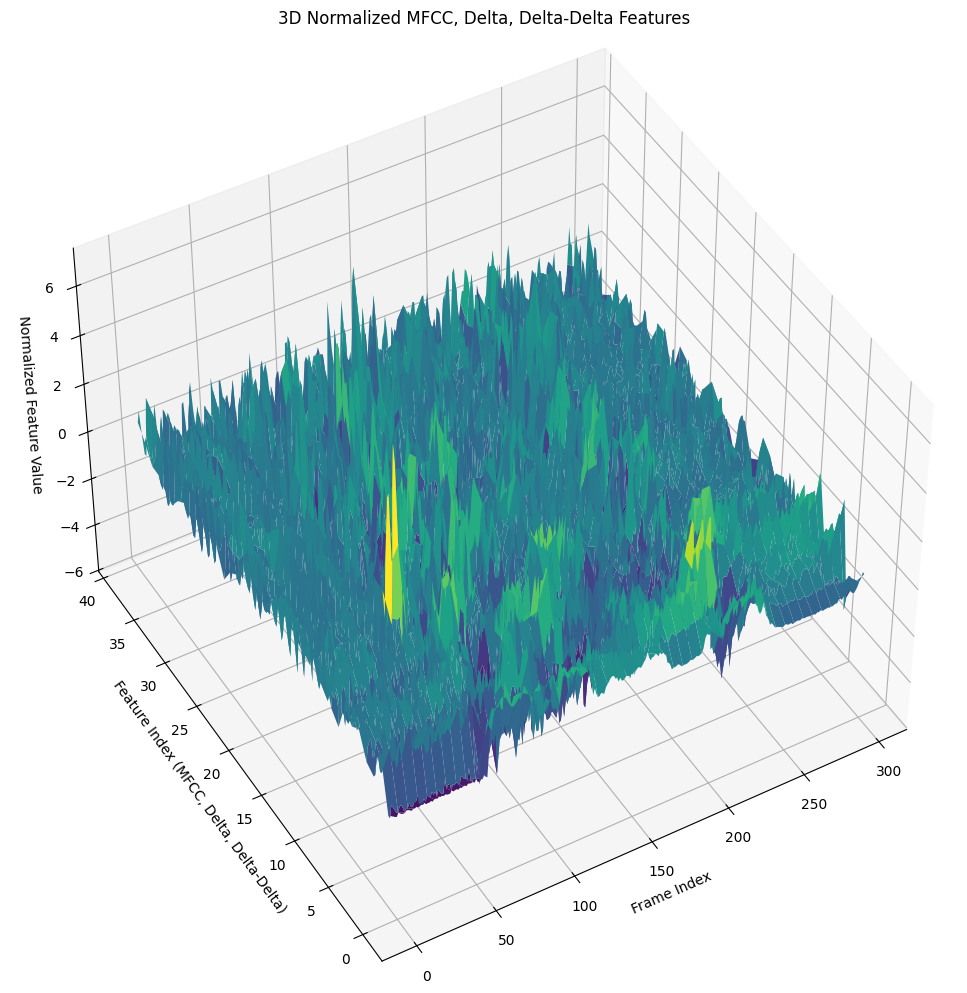

CVN Features Shape: (298, 39)
Features of Frame 10:
MFCC Features: [-6.56835946e+02 -1.04615946e+02 -2.04381757e+01 -2.01455269e+01
 -7.74319034e+00 -7.13262187e+00 -3.76622567e+00 -5.48103116e-01
  9.29752169e-01 -4.07647937e+00 -2.24731897e+00 -5.09770325e+00
 -4.21232092e+00]
Delta Features: [-1.68659450e+00 -3.25826116e+00 -2.31424565e+00 -6.23117210e-01
 -1.28477288e-01  1.02950431e-01 -7.33349786e-01 -7.42668178e-01
 -4.44885237e-01  2.88821296e-01  2.53435847e-03 -8.94112300e-01
 -4.02879135e-01]
Delta-Delta Features: [ 1.15289609  1.32608668  1.01746356  0.75623332  0.201029    0.30986893
  0.13629675 -0.06858415  0.21861566  0.55889197  0.11526254  0.43494712
  0.43879746]
Stacked and Normalized Features: [-1.60305722 -2.04939922  0.17342934 -1.18436225 -0.65684978 -0.0054048
 -0.404564    0.43307149 -0.40503805 -0.79730381  0.29876021 -1.05956171
 -0.3684657  -0.15034416 -0.67870938 -0.5863473  -0.2633438  -0.04570691
  0.06285391 -0.36879379 -0.39746633 -0.27028445  0.207493

In [9]:
# Stack the MFCC, Delta, and Delta-Delta features horizontally (combine them into one feature set)
stacked_features = np.hstack((mfcc_features, delta1, delta2))

# Mean normalization: subtract the mean of each feature across all frames
cmn_features = stacked_features - np.mean(stacked_features, axis=0)

# Variance normalization: divide by the standard deviation of each feature
cvn_features = cmn_features / np.std(cmn_features, axis=0)

#################################################################################
#                      Visualization and Data Presentation                      #
#################################################################################

# 3D plot of the normalized MFCC, Delta, and Delta-Delta features
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Create meshgrid for time (frame index) and feature index (MFCC, Delta, Delta-Delta)
time_indices = np.arange(cvn_features.shape[0])
feature_indices = np.arange(cvn_features.shape[1])
time_mesh, feature_mesh = np.meshgrid(time_indices, feature_indices)

# Transpose the normalized features for 3D plotting
cvn_features_3d = cvn_features.T

# Plot the 3D surface of the normalized MFCC, Delta, and Delta-Delta features
ax.plot_surface(time_mesh, feature_mesh, cvn_features_3d, cmap='viridis', edgecolor='none')
ax.set_title('3D Normalized MFCC, Delta, Delta-Delta Features')
ax.set_xlabel('Frame Index')
ax.set_ylabel('Feature Index (MFCC, Delta, Delta-Delta)')
ax.set_zlabel('Normalized Feature Value')
ax.view_init(45, -120)
plt.tight_layout()
plt.show()

# Print the shape of the normalized feature matrix
print('CVN Features Shape:', cvn_features.shape)

# Print the features of a specific frame (e.g., frame 10)
frame_number = 10
print(f'Features of Frame {frame_number}:')
print('MFCC Features:', mfcc_features[frame_number])
print('Delta Features:', delta1[frame_number])
print('Delta-Delta Features:', delta2[frame_number])
print('Stacked and Normalized Features:', cvn_features[frame_number])

# 10 - Principal Component Analysis (PCA)

PCA is performed to reduce the dimensionality of the feature set while retaining the most important information. By keeping only the most significant principal components, this step helps to remove redundancy and improve computational efficiency.

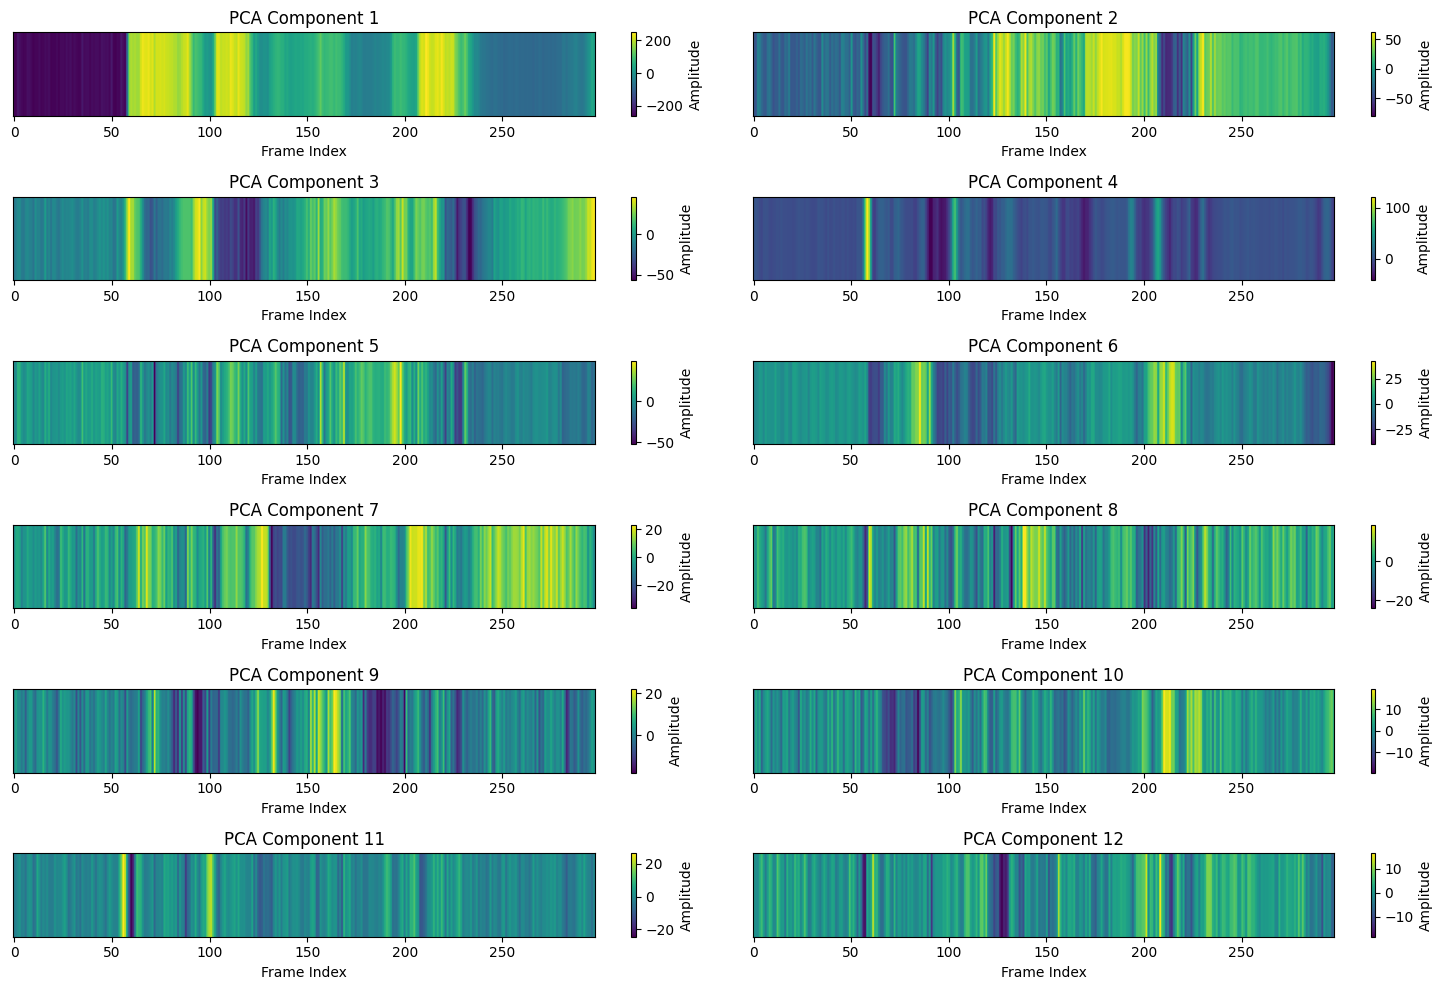

Explained variance ratio of each PCA component:
Component 1: 0.9018
Component 2: 0.0416
Component 3: 0.0170
Component 4: 0.0106
Component 5: 0.0077
Component 6: 0.0055
Component 7: 0.0051
Component 8: 0.0020
Component 9: 0.0018
Component 10: 0.0013
Component 11: 0.0011
Component 12: 0.0010

PCA Component Feature Vectors:
[[ 9.55935917e-01  2.82244670e-01 -7.14683754e-02 -2.17856978e-03
   1.65028492e-03 -7.14831227e-03 -2.26496895e-02 -9.90888464e-03
   1.38571187e-02 -2.17438110e-03 -5.39579570e-03  1.49903505e-02
  -1.12597231e-02 -4.57764879e-03 -1.00780667e-04  1.27316472e-03
  -8.62260192e-04 -9.11454360e-04 -7.98549294e-04 -9.28163454e-04
   4.83518497e-04  8.86153629e-04  2.02966955e-04  5.80748541e-05
  -1.35406474e-04 -1.71484470e-04 -1.18647807e-02 -1.05579575e-03
   8.03712048e-04  2.52882293e-04  2.82353971e-04 -2.21419627e-05
   2.35333724e-04  8.54948822e-05  1.63754044e-05  1.47762301e-04
  -9.41980361e-05 -2.82027764e-04 -2.37016457e-05]
 [-2.39976498e-01  8.82951107e-0

In [10]:
def feature_transformation(features, n_components=12):
    """
    Perform Principal Component Analysis (PCA) on the feature set.

    Args:
        features (numpy.ndarray): The input features to be transformed.
        n_components (int): Number of principal components to keep.

    Returns:
        tuple: (Transformed features, PCA object)
    """
    # Initialize PCA with the desired number of components
    pca = PCA(n_components=n_components)

    # Fit the PCA model to the features and transform the data
    transformed_features = pca.fit_transform(features)

    return transformed_features, pca

# Apply PCA to reduce the dimensionality of the stacked features (MFCC, Delta, Delta-Delta)
transformed_features, pca_model = feature_transformation(stacked_features)

#################################################################################
#                      Visualization and Data Presentation                      #
#################################################################################

# Plot the transformed features for each PCA component
plt.figure(figsize=(15, 10))
for i in range(transformed_features.shape[1]):
    # Plot each PCA component as a heatmap across time frames
    plt.subplot(6, 2, i + 1)
    plt.imshow(transformed_features[:, i].reshape(-1, 1).T, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='Amplitude', orientation='vertical')
    plt.title(f'PCA Component {i + 1}')
    plt.xlabel('Frame Index')
    plt.yticks([])
plt.tight_layout()
plt.show()

# Print the explained variance ratio for each PCA component
explained_variance = pca_model.explained_variance_ratio_
print('Explained variance ratio of each PCA component:')
for i, variance in enumerate(explained_variance):
    print(f'Component {i + 1}: {variance:.4f}')

# Print the PCA component feature vectors
print('\nPCA Component Feature Vectors:')
print(pca_model.components_)

# Print the transformed features for a specific frame (e.g., frame 10)
frame_number = 10
print(f'\nPCA Transformed Features of Frame {frame_number}:')
print(transformed_features[frame_number])

#################################################################################
#                          Save Features to a npy File                          #
#################################################################################

np.save('Features.npy', mfcc_features)

# 11 - Comparison with `librosa` MFCC

In this step, we compare the custom MFCC implementation with the MFCCs generated by the librosa library to validate our custom implementation.

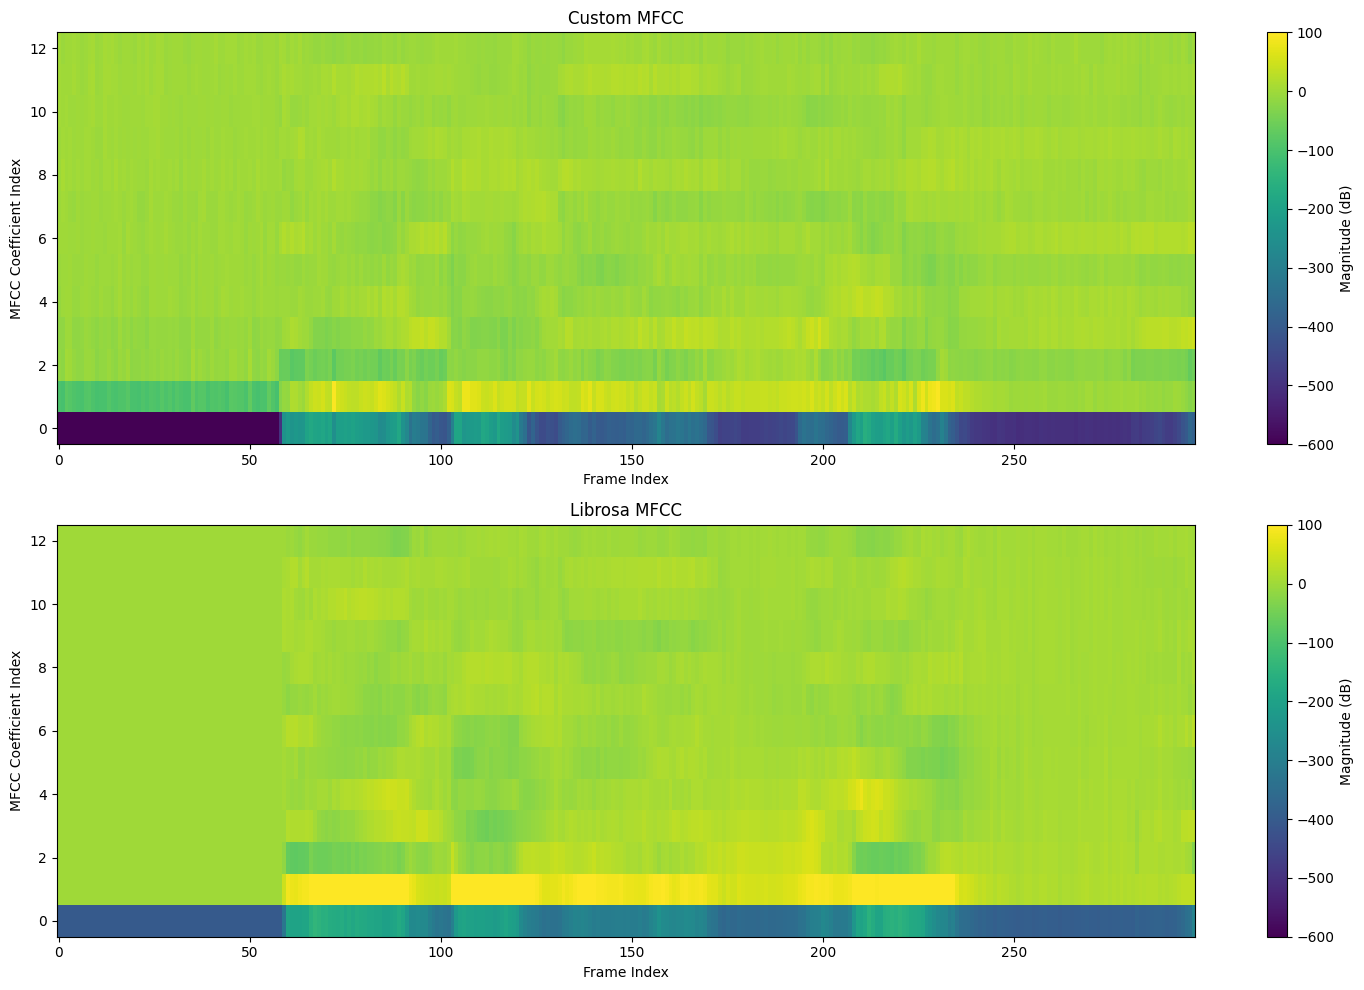

In [11]:
# Calculate the hop length based on the frame stride and sampling rate
hop_length = int(frame_stride * fs)

# Use librosa to compute MFCCs directly from the signal
librosa_mfcc = librosa.feature.mfcc(y=signal, sr=fs, n_mfcc=13, n_fft=NFFT, hop_length=hop_length, n_mels=num_filters)

# Ensure the custom MFCCs and librosa MFCCs have the same shape by trimming or padding as necessary
if librosa_mfcc.shape[1] > mfcc_features.shape[0]:
    # Trim the librosa MFCC to match the custom MFCC length
    librosa_mfcc = librosa_mfcc[:, :mfcc_features.shape[0]]
elif librosa_mfcc.shape[1] < mfcc_features.shape[0]:
    # Trim the custom MFCC to match the librosa MFCC length
    mfcc_features = mfcc_features[:librosa_mfcc.shape[1], :]

#################################################################################
#                      Visualization and Data Presentation                      #
#################################################################################

# Plot the custom MFCC
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.imshow(mfcc_features.T, aspect='auto', origin='lower', cmap='viridis', vmin=-600, vmax=100)
plt.title('Custom MFCC')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Frame Index')
plt.ylabel('MFCC Coefficient Index')

# Plot the librosa MFCC
plt.subplot(2, 1, 2)
plt.imshow(librosa_mfcc, aspect='auto', origin='lower', cmap='viridis', vmin=-600, vmax=100)
plt.title('Librosa MFCC')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Frame Index')
plt.ylabel('MFCC Coefficient Index')

# Show the comparison plots
plt.tight_layout()
plt.show()